<a href="https://colab.research.google.com/github/Folkas/folkas-portfolio/blob/main/Adoption_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 3: Machine Learning

## Sprint 4: Machine Learning capstone project

## Kaggle competition with a complex dataset

## Background

---

Participating in Kaggle competitions is an efficient way to learn some aspects of Machine Learning. You can read solutions made public by the others, participate in the discussions to talk about solution ideas and test them by submitting them for evaluation.

The metric used for evaluation can vary from competition to competition, but the idea remains the same - build a model that is as accurate as possible on the testing set. In industry, there are other factors to consider when building machine learning models - inference time, solution complexity, maintainability and so on. However, even though you only learn a subset of the required skills while participating in Kaggle competitions, it is quite a fun way to learn by doing it, so let's participate in one of the competitions again! This time, a competition having a really complex dataset.

## The competition

Pick and participate in one of the following Kaggle competitions, where they all have complex datasets, which creates a lot of space for creative feature engineering and model building:

- https://www.kaggle.com/c/petfinder-adoption-prediction/overview
- https://www.kaggle.com/c/avito-demand-prediction/overview
- https://www.kaggle.com/c/home-credit-default-risk/overview

For help, you can look at some of the notebooks by other competitors. However, try to write code by yourself, as even though you will always be able to consult external resources while working as a professional, the main thing right now to is learn, not to get a good score in the leaderboard.

---

## Requirements

- Data exploration
- Feature engineering
- At least several different models built and compared to each other on the validation set and on the public and private leaderboards
- Clean code
- At least median private leaderboard score: **0.37084**

## Evaluation criteria

- Private leaderboard score
- How simple is the model
- How fast is the model prediction
- Code quality

#Capstone Project

In [ ]:
!pip install --upgrade scikit-learn==0.20.3
!pip install optuna
!pip install imbalanced-learn

  Using cached https://files.pythonhosted.org/packages/aa/cc/a84e1748a2a70d0f3e081f56cefc634f3b57013b16faa6926d3a6f0598df/scikit_learn-0.20.3-cp37-cp37m-manylinux1_x86_64.whl
  Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [ ]:
!unzip pets.zip

Archive:  pets.zip
  inflating: test/sample_submission.csv  
  inflating: test/test.csv           
  inflating: train/breed_labels.csv  
  inflating: train/color_labels.csv  
  inflating: train/state_labels.csv  
  inflating: train/train.csv         


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
import lightgbm as lgb
import sklearn.metrics
import xgboost as xgb
from imblearn.over_sampling import SMOTE
RANDOM_STATE = 8

# defining cohen kappa score evaluation function

def kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")
kappa_scorer = make_scorer(cohen_kappa_score, weights="quadratic")

In [ ]:
# # importing sentimental data for train data set
# import json

# sentiment_dict = {}
# for filename in os.listdir("../input/petfinder-adoption-prediction/train_sentiment/"):
#     with open(
#         "../input/petfinder-adoption-prediction/train_sentiment/" + filename, "r"
#     ) as f:
#         sentiment = json.load(f)
#     pet_id = filename.split(".")[0]
#     sentiment_dict[pet_id] = {}
#     sentiment_dict[pet_id]["magnitude"] = sentiment["documentSentiment"]["magnitude"]
#     sentiment_dict[pet_id]["score"] = sentiment["documentSentiment"]["score"]
#     sentiment_dict[pet_id]["language"] = sentiment["language"]

# train["lang"] = train["PetID"].apply(
#     lambda x: sentiment_dict[x]["language"] if x in sentiment_dict else "no"
# )
# train["magnitude"] = train["PetID"].apply(
#     lambda x: sentiment_dict[x]["magnitude"] if x in sentiment_dict else 0
# )
# train["score"] = train["PetID"].apply(
#     lambda x: sentiment_dict[x]["score"] if x in sentiment_dict else 0
# )


# # for test data set
# sentiment_test_dict = {}
# for filename in os.listdir("../input/petfinder-adoption-prediction/test_sentiment/"):
#     with open(
#         "../input/petfinder-adoption-prediction/test_sentiment/" + filename, "r"
#     ) as f:
#         sentiment = json.load(f)
#     pet_id = filename.split(".")[0]
#     sentiment_test_dict[pet_id] = {}
#     sentiment_test_dict[pet_id]["magnitude"] = sentiment["documentSentiment"][
#         "magnitude"
#     ]
#     sentiment_test_dict[pet_id]["score"] = sentiment["documentSentiment"]["score"]
#     sentiment_test_dict[pet_id]["language"] = sentiment["language"]

# test["lang"] = test["PetID"].apply(
#     lambda x: sentiment_dict[x]["language"] if x in sentiment_dict else "no"
# )
# test["magnitude"] = test["PetID"].apply(
#     lambda x: sentiment_dict[x]["magnitude"] if x in sentiment_dict else 0
# )
# test["score"] = test["PetID"].apply(
#     lambda x: sentiment_dict[x]["score"] if x in sentiment_dict else 0
# )

# # creating new feature DescriptionLength
# train["DescriptionLength"] = (
#     train["Description"].str.split().str.len().fillna(0.0).astype(int)
# )
# test["DescriptionLength"] = (
#     test["Description"].str.split().str.len().fillna(0.0).astype(int)
# )

# test.to_csv("test_w_sentiment_no_mappings.csv", index=False)
# train.to_csv("train_w_sentiment_no_mappings.csv", index=False)

In [ ]:
train = pd.read_csv("train/train.csv")
breeds = pd.read_csv("train/breed_labels.csv")
colors = pd.read_csv("train/color_labels.csv")
states = pd.read_csv("train/state_labels.csv")
test = pd.read_csv("test/test.csv")
test_sentimental = pd.read_csv("test_w_sentiment_no_mappings.csv")
train_sentimental = pd.read_csv("train_w_sentiment_no_mappings.csv")

# transforming float PhotoAmt into int
train.PhotoAmt = train.PhotoAmt.astype("int")
test.PhotoAmt = test.PhotoAmt.astype("int")
train_sentimental.PhotoAmt = train_sentimental.PhotoAmt.astype("int")
test_sentimental.PhotoAmt = test_sentimental.PhotoAmt.astype("int")

##EDA

###Feature descriptions 
(copied from [Kaggle](https://www.kaggle.com/c/petfinder-adoption-prediction/data))
* **PetID** - Unique hash ID of pet profile
* **AdoptionSpeed** - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
* **Type** - Type of animal (1 = Dog, 2 = Cat)
* **Name** - Name of pet (Empty if not named)
* **Age** - Age of pet when listed, in months
* **Breed1** - Primary breed of pet (Refer to BreedLabels dictionary)
* **Breed2** - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* **Gender** - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* **Color1** - Color 1 of pet (Refer to ColorLabels dictionary)
* **Color2** - Color 2 of pet (Refer to ColorLabels dictionary)
* **Color3** - Color 3 of pet (Refer to ColorLabels dictionary)
* **MaturitySize** - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* **FurLength** - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* **Vaccinated** - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* **Dewormed** - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* **Sterilized** - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* **Health** - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* **Quantity** - Number of pets represented in profile
* **Fee** - Adoption fee (0 = Free)
* **State** - State location in Malaysia (Refer to StateLabels dictionary)
* **RescuerID** - Unique hash ID of rescuer
* **VideoAmt** - Total uploaded videos for this pet
* **PhotoAmt** - Total uploaded photos for this pet
* **Description** - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

#### **Train/Test Sentimental data**:
* **DescriptionLength** (created) - Number of words in ```Description```
* **score** and **magnitude** - Features analyzing sentiment and key entities obtained from Google's Natural Language API
* **lang** - language of description

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Type           14993 non-null  int64 
 1   Name           13736 non-null  object
 2   Age            14993 non-null  int64 
 3   Breed1         14993 non-null  int64 
 4   Breed2         14993 non-null  int64 
 5   Gender         14993 non-null  int64 
 6   Color1         14993 non-null  int64 
 7   Color2         14993 non-null  int64 
 8   Color3         14993 non-null  int64 
 9   MaturitySize   14993 non-null  int64 
 10  FurLength      14993 non-null  int64 
 11  Vaccinated     14993 non-null  int64 
 12  Dewormed       14993 non-null  int64 
 13  Sterilized     14993 non-null  int64 
 14  Health         14993 non-null  int64 
 15  Quantity       14993 non-null  int64 
 16  Fee            14993 non-null  int64 
 17  State          14993 non-null  int64 
 18  RescuerID      14993 non-n

In [ ]:
train.shape

(14993, 24)

The train data set has **23 features** and nearly **15,000 observations**. Most variables are ```int64``` type. However, this information is deceptive, as several numerical features are categorical, in fact. Before analyzing data, I need to perform some feature transformation.

In [ ]:
train.isnull().any()

Type             False
Name              True
Age              False
Breed1           False
Breed2           False
Gender           False
Color1           False
Color2           False
Color3           False
MaturitySize     False
FurLength        False
Vaccinated       False
Dewormed         False
Sterilized       False
Health           False
Quantity         False
Fee              False
State            False
RescuerID        False
VideoAmt         False
Description       True
PetID            False
PhotoAmt         False
AdoptionSpeed    False
dtype: bool

I can see that there are missing values only in ```Name``` and ```Description``` variables.

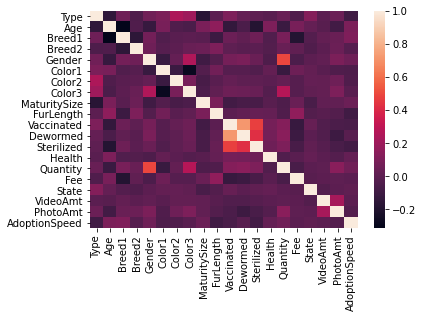

In [ ]:
correlations = train.corr()
sns.heatmap(correlations)

The heatmap shows weak or no correlation among features and the target.

###Data Analysis

In [ ]:
# mapping colors into train dataset
color = dict(colors[["ColorID", "ColorName"]].values)
color[0] = "No color"  # values with 0 will be labeled as "No color"
train.Color1 = train.Color1.map(color)
train.Color2 = train.Color2.map(color)
train.Color3 = train.Color3.map(color)

# mapping state names into train dataset
state = dict(states[["StateID", "StateName"]].values)
train.State = train.State.map(state)

# transforming numerical columns into categoricals
train.Sterilized = train.Sterilized.map({1: "Yes", 2: "No", 3: "Not Sure"})
train.Gender = train.Gender.map({1: "Male", 2: "Female", 3: "Mixed"})
train.Vaccinated = train.Vaccinated.map({1: "Yes", 2: "No", 3: "Not Sure"})
train.Dewormed = train.Dewormed.map({1: "Yes", 2: "No", 3: "Not Sure"})
train.Type = train.Type.map({1: "Dog", 2: "Cat"})

# mapping breeds names into train dataset
breed = dict(breeds[["BreedID", "BreedName"]].values)
train.Breed1 = train.Breed1.map(breed)
train.Breed2 = train.Breed2.map(breed)

# transforming float PhotoAmt into int
train.PhotoAmt = train.PhotoAmt.astype("int")

# setting plotting style
plt.style.use("tableau-colorblind10")

####Target variable

Text(0, 0.5, '')

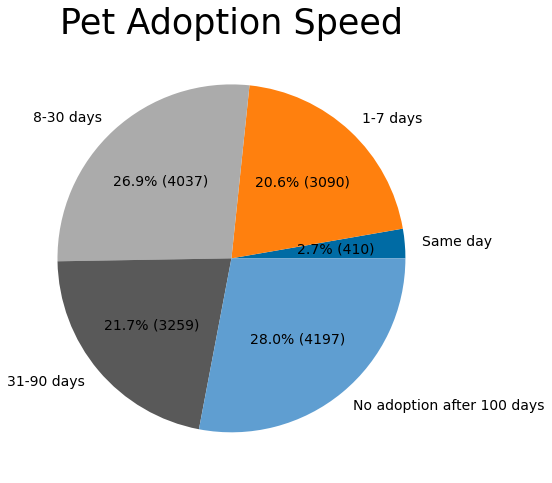

In [ ]:
# analyzing target variable distribution

adoption_info = train.groupby("AdoptionSpeed").size()
adoption_info.plot(
    kind="pie",
    title="Pet Adoption Speed",
    figsize=[8, 8],
    autopct=lambda p: "{:.1f}% ({:.0f})".format(p, (p / 100) * adoption_info.sum()),
    fontsize=14,
    labels=[
        "Same day",
        "1-7 days",
        "8-30 days",
        "31-90 days",
        "No adoption after 100 days",
    ],
).title.set_size(35)
plt.ylabel("")

The pie chart above shows the distribution of ```AdoptionSpeed``` (target variable) of pets. We can see that very few pets (2.7%) are usually adopted on the same day. In contrast, most pets (28.0%) aren't adopted within 100 days at all. What is interesting is that the majority of pets are adopted within 8-30 days (26.9%). Meanwhile, a similar share of pets are adopted in the first week and first three months (20.6% and 21.7%, respectively).

**Conclusions:**
* Nearly a third of pets are not adopted after 100 days.
* Almost 50% of pets are adopted within the first month.

####Pet Type and Gender

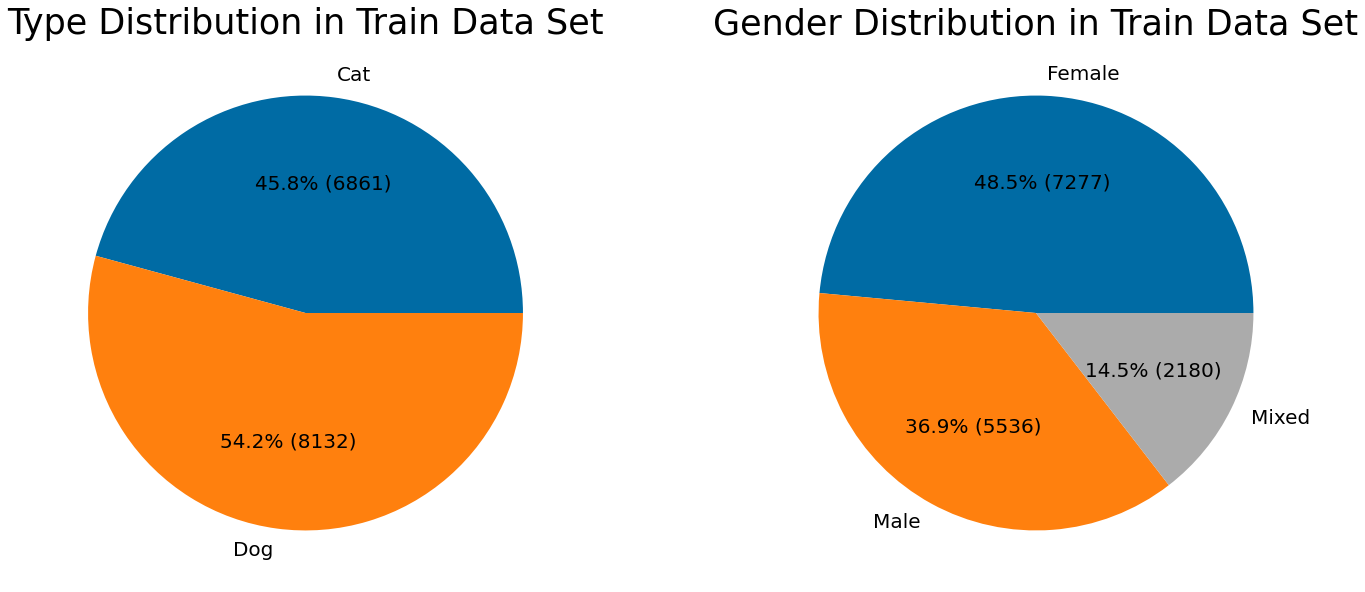

In [ ]:
iter = ["Type", "Gender"]
for i, column in enumerate(iter):
    plt.subplot(1, 2, i + 1)
    infoplot = train.groupby(f"{column}").size()
    infoplot.plot(
        kind="pie",
        title=f"{column} Distribution in Train Data Set",
        figsize=(24, 10),
        autopct=lambda p: "{:.1f}% ({:.0f})".format(p, (p / 100) * infoplot.sum()),
        fontsize=20,
    ).title.set_size(35)
    plt.ylabel("")

```Type``` and ```Gender``` feature distributions are piecharted above. It seems that dogs outnumber cats (54% vs. 46%). Also, the data set has more female (7,277) than male (5,536) pets. 

However, if we look at ```AdoptionSpeed``` (lower variable values mean quicker adoption) grouped by pet type (cat or dog) in the table below, we will see cats are more numerous than dogs in lower categories. In other words, cats, despite being fewer in number, are sooner adopted than dogs.

In [ ]:
train.groupby(["AdoptionSpeed", "Type"]).size().to_frame(name="Count")

Count
AdoptionSpeed Type       
0             Cat     240
              Dog     170
1             Cat    1655
              Dog    1435
2             Cat    1873
              Dog    2164
3             Cat    1310
              Dog    1949
4             Cat    1783
              Dog    2414

#### Pet Age


Text(0, 0.5, '')

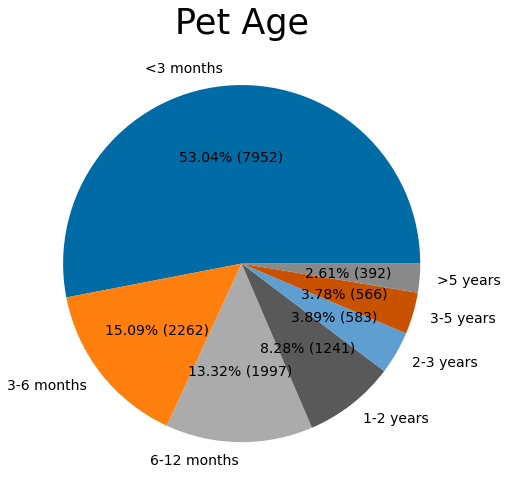

In [ ]:
bins = [0, 3, 6, 12, 24, 36, 60, 255]
labels = [
    "<3 months",
    "3-6 months",
    "6-12 months",
    "1-2 years",
    "2-3 years",
    "3-5 years",
    ">5 years",
]
train["AgeRange"] = pd.cut(train.Age, bins, include_lowest=True, labels=labels)
age_range = train.groupby("AgeRange").size()
age_range.plot(
    kind="pie",
    title="Pet Age",
    autopct=lambda p: "{:.2f}% ({:.0f})".format(p, (p / 100) * age_range.sum()),
    fontsize=14,
    figsize=(8, 10),
).title.set_size(35)
plt.ylabel("")

The pie chart above depicts pets' ```Age```. It seems that more than 50% of all pets for adoption are younger than 3 months. Next, about 15% of pets are 3-6 months old. There are slightly fewer pets of age 6-12 months (around 13 per cent). Moving on, we can see that as age increases, there are fewer and fewer pets abandoned for adoption. Let's see how pets' chances to be adopted variate as they age.

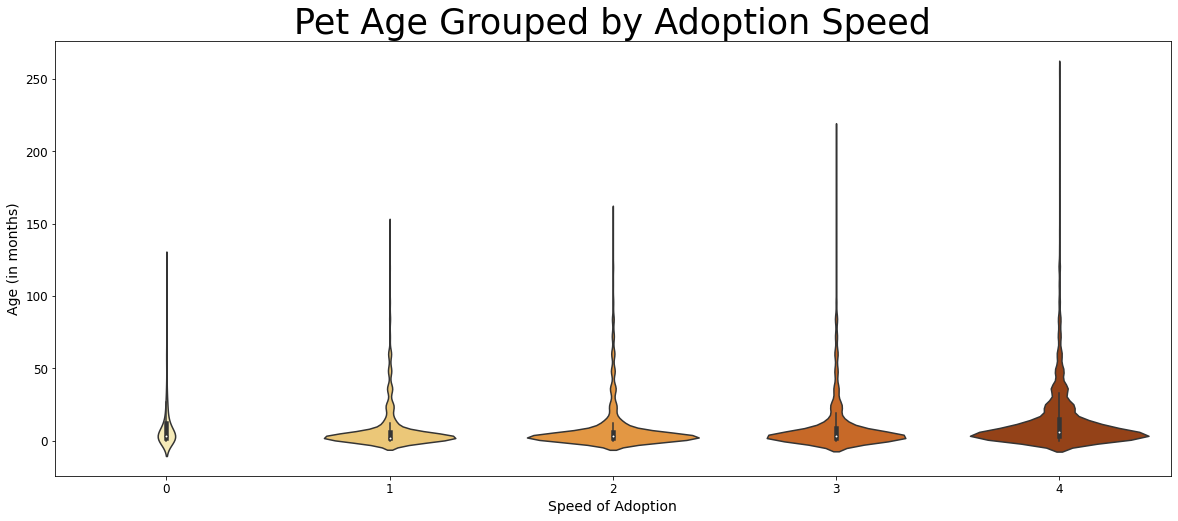

In [ ]:
plt.figure(figsize=(20, 8))
g = sns.violinplot(
    data=train, y="Age", x="AdoptionSpeed", scale="count", palette="YlOrBr"
)
g.set_title("Pet Age Grouped by Adoption Speed", fontsize=35)
g.set_xlabel("Speed of Adoption", fontsize=14)
g.set_ylabel("Age (in months)", fontsize=14)
g.tick_params(labelsize=12)

The violin plot above shows the distribution of pets' ```Age``` across 5 levels of ```AdoptionSpeed```. The widths of violins are scaled by the number of observations in each violin to keep the proportions. We can see that all violins retain very similar distributions for young pets (up to 24 months old). In other words, young age is not linked to the speed of adoption. On the other hand, we observe longer whiskers as AdoptionSpeed increases. They indicate that whilst there are few older pets for adoption, they are more likely to be adopted later or not adopted at all.

####Uploaded Photos

<Figure size 1440x576 with 0 Axes>

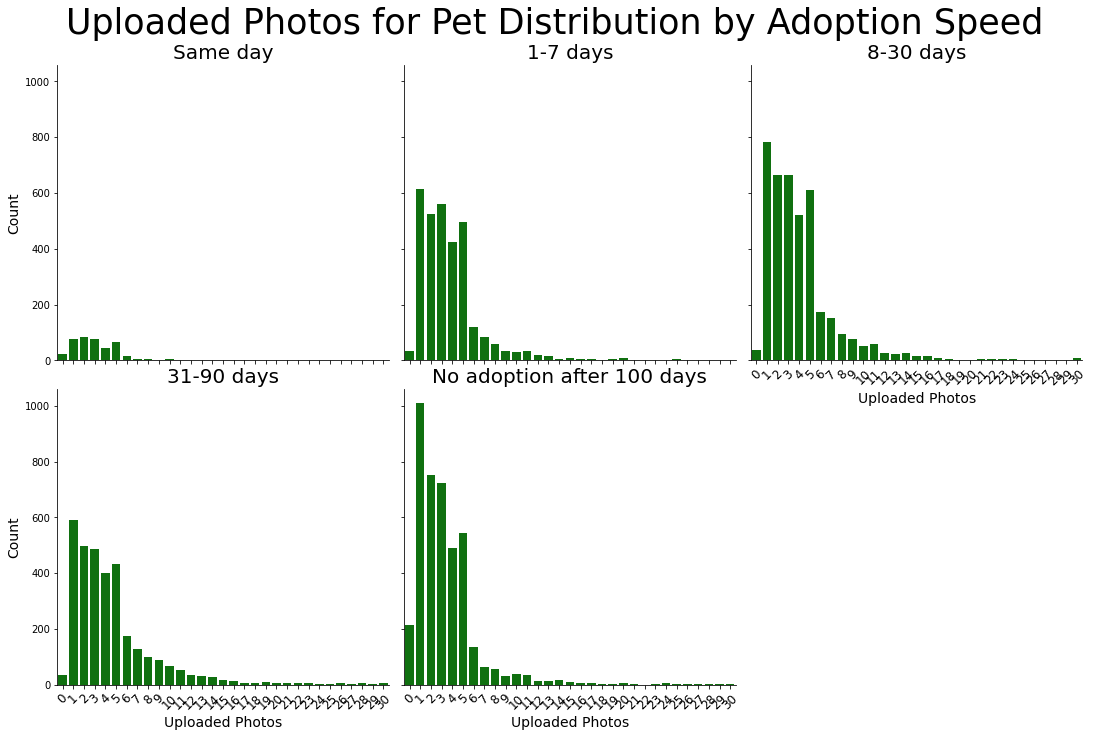

In [ ]:
plt.figure(figsize=(20, 8))
h = (
    sns.catplot(
        data=train,
        x="PhotoAmt",
        col="AdoptionSpeed",
        col_wrap=3,
        kind="count",
        color="green",
    )
    .set_axis_labels("Uploaded Photos", "Count", size=14)
    .set_xticklabels(rotation=45, size=12)
)
h.fig.subplots_adjust(top=0.9)
h.fig.suptitle("Uploaded Photos for Pet Distribution by Adoption Speed", fontsize=35)


labels = [
    "Same day",
    "1-7 days",
    "8-30 days",
    "31-90 days",
    "No adoption after 100 days",
]
axes = h.axes.flatten()
for i, label in enumerate(labels):
    axes[i].set_title(f"{label}", fontsize=20)

The histogram above plots ```PhotoAmt``` frequencies distributed by ```AdoptionSpeed```. Looking at the plot, we do not see that the number of photos could influence the speed of pet's adoption.

**Conclusions:**
* There are more dogs than cats for adoption, but cats are on average adapted sooner than dogs.
* Older pets are adopted later or not at all.

####Physical Appearance

#####Maturity Size

Text(0, 0.5, '')

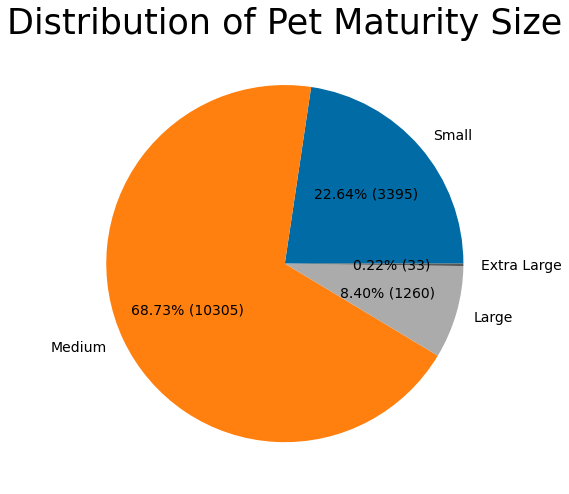

In [ ]:
mat_size = train.groupby("MaturitySize").size()
mat_size.plot(
    kind="pie",
    title="Distribution of Pet Maturity Size",
    autopct=lambda p: "{:.2f}% ({:.0f})".format(p, (p / 100) * mat_size.sum()),
    labels=["Small", "Medium", "Large", "Extra Large"],
    fontsize=14,
    figsize=(8, 10),
).title.set_size(35)
plt.ylabel("")

The plot above shows that most pets for adoption are medium (10,305) and small (3,395) size. However, according to the barplot below, pet size does not have impact for adoption speed.

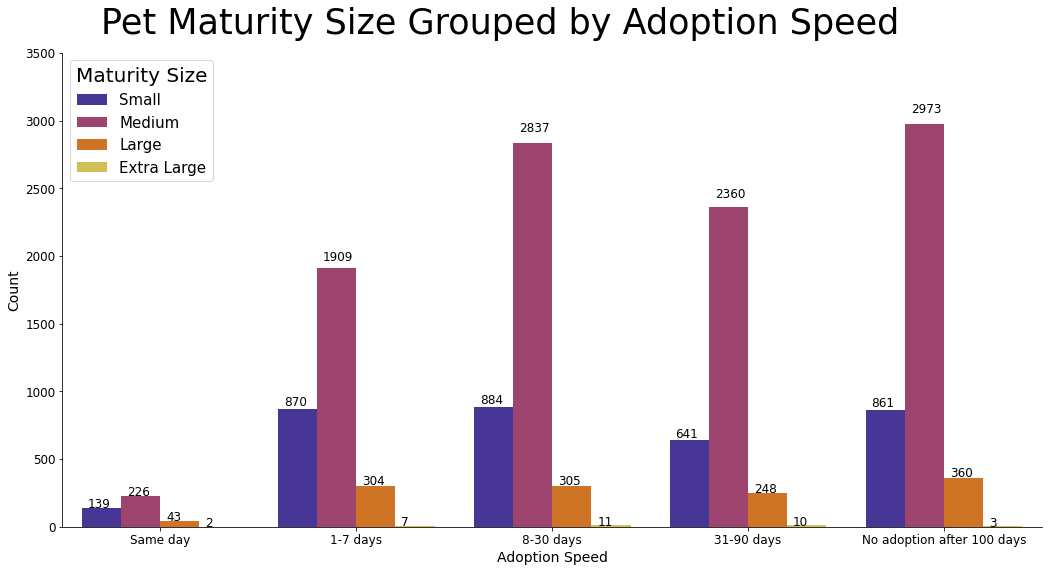

In [ ]:
j = (sns.catplot(data=train, hue="MaturitySize", x="AdoptionSpeed", kind="count", legend=False, palette="CMRmap")
.set_xticklabels(["Same day", "1-7 days", "8-30 days", "31-90 days", "No adoption after 100 days"], size=12)
.set_yticklabels(size=12))
j.fig.suptitle('Pet Maturity Size Grouped by Adoption Speed', fontsize=35)
j.fig.subplots_adjust(top=0.9)
j.fig.set_size_inches(16,8)
plt.legend(title='Maturity Size', loc='upper left', fontsize=15, title_fontsize=20, labels=["Small", "Medium", "Large", "Extra Large"])
plt.xlabel("Adoption Speed", fontsize=14)
plt.ylabel("Count", fontsize=14)
ax = j.facet_axis(0,0)

for p in ax.patches:
    ax.text(p.get_x() + 0.03, 
            p.get_height() * 1.03, 
           '{0:.0f}'.format(p.get_height()),   
            color='black', 
            rotation='horizontal', 
            size='large')

#####Fur Length

Text(0, 0.5, '')

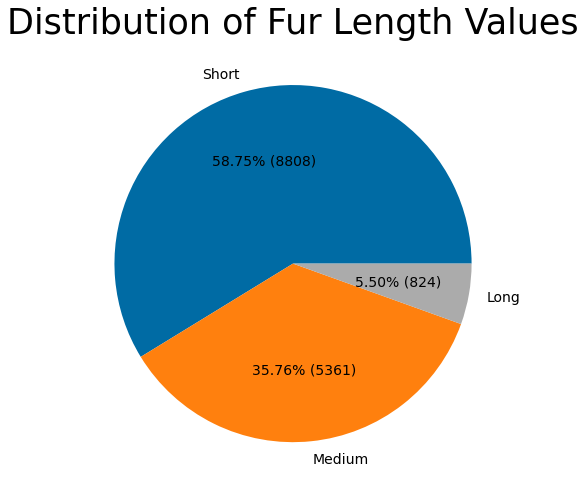

In [ ]:
fur_length = train.groupby("FurLength").size()
fur_length.plot(
    kind="pie",
    title="Distribution of Fur Length Values",
    autopct=lambda p: "{:.2f}% ({:.0f})".format(p, (p / 100) * fur_length.sum()),
    labels=["Short", "Medium", "Long"],
    fontsize=14,
    figsize=(8, 10),
).title.set_size(35)
plt.ylabel("")

As the pie chart above shows, nearly 60% of pets for adoptions have short fur. Around 36% of pets are of medium fur length, while just a bit more than 5% have long fur. If we look at the distribution of ```FurLength``` grouped by ```AdoptionSpeed```, we will not notice any patterns in pets being adopted sooner due to fur length, as ```FurLength``` distributions in the countplot keep similar proportions as in the pie chart above. It seems that people do not consider fur length when selecting pets for adoption.

<Figure size 1440x1440 with 0 Axes>

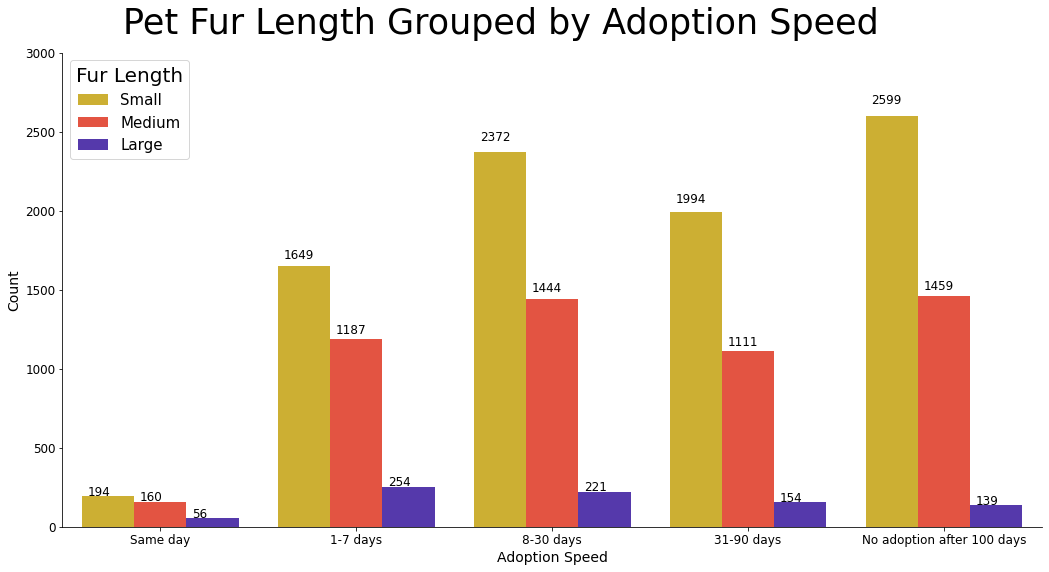

In [ ]:
plt.figure(figsize=(20,20))
j = (sns.catplot(data=train, hue="FurLength", x="AdoptionSpeed", kind="count", legend=False, palette="CMRmap_r").set_xticklabels(["Same day", "1-7 days", "8-30 days", "31-90 days", "No adoption after 100 days"])
.set_xticklabels(["Same day", "1-7 days", "8-30 days", "31-90 days", "No adoption after 100 days"], size=12)
.set_yticklabels(size=12))
j.fig.suptitle('Pet Fur Length Grouped by Adoption Speed', fontsize=35)
j.fig.subplots_adjust(top=0.9)
j.fig.set_size_inches(16,8)
plt.xlabel("Adoption Speed", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(title='Fur Length', loc='upper left', labels=["Small", "Medium", "Large", "Extra Large"], fontsize=15, title_fontsize=20)

ax = j.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.03, 
            p.get_height() * 1.03, 
           '{0:.0f}'.format(p.get_height()),   
            color='black', 
            rotation='horizontal', 
            size='large')

**Conclusions:**
* When it comes to pet's maturity or fur length, these patterns do not seemingly explain speed of adoption.

#####Color1 and Color2

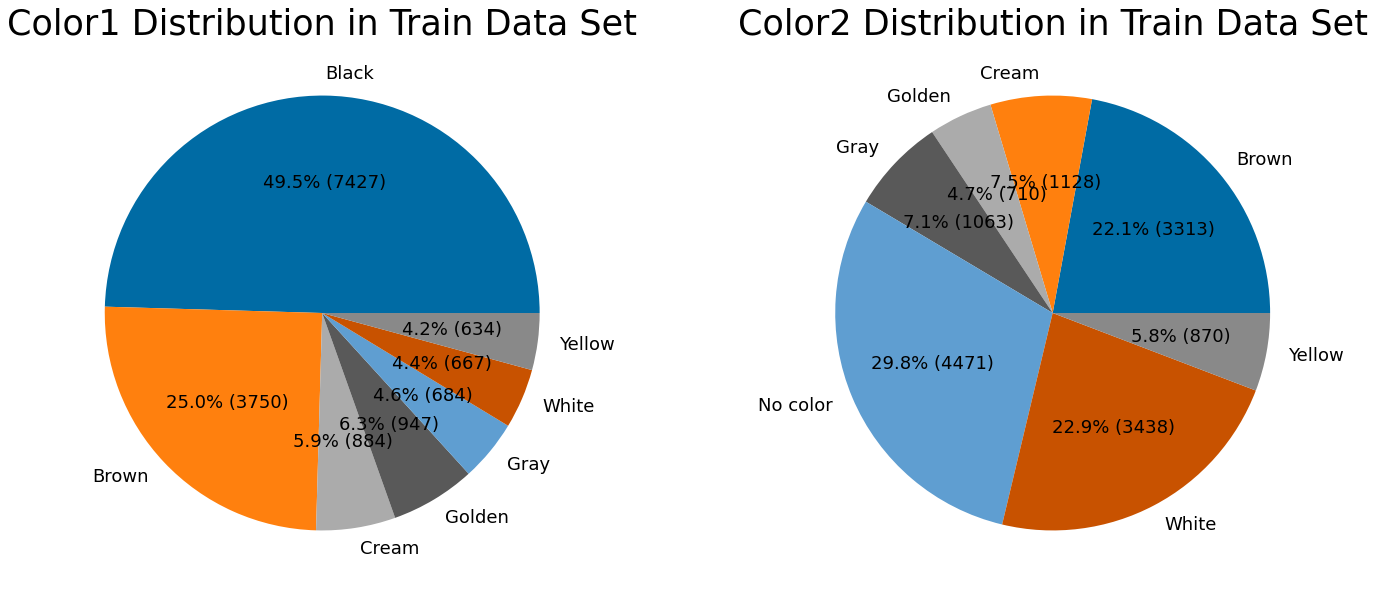

In [ ]:
iter = ["Color1", "Color2"]
for i, column in enumerate(iter):
  plt.subplot(1, 2, i+1)
  infoplot = train.groupby(f"{column}").size()
  infoplot.plot(kind='pie', title=f"{column} Distribution in Train Data Set", figsize=(24, 10),
          autopct=lambda p: '{:.1f}% ({:.0f})'.format(p,(p/100)*infoplot.sum()), fontsize=18).title.set_size(35)
  plt.ylabel("")

Both pie charts above display distributions of ```Color1``` and ```Color2``` variables, or pets' first and second colors. The pie chart on the left shows that approximately half of pets have black as the first color. A quarter of pets for adoption are predominantly brown. The fewest pets are gray, white and yellow.

The pie chart on the right (```Color2```) highlights that nearly a third of pets have no color, i.e. they're one-color. Two other most frequent colors are white and brown. Meanwhile, two least frequent second colors are yellow and golden.

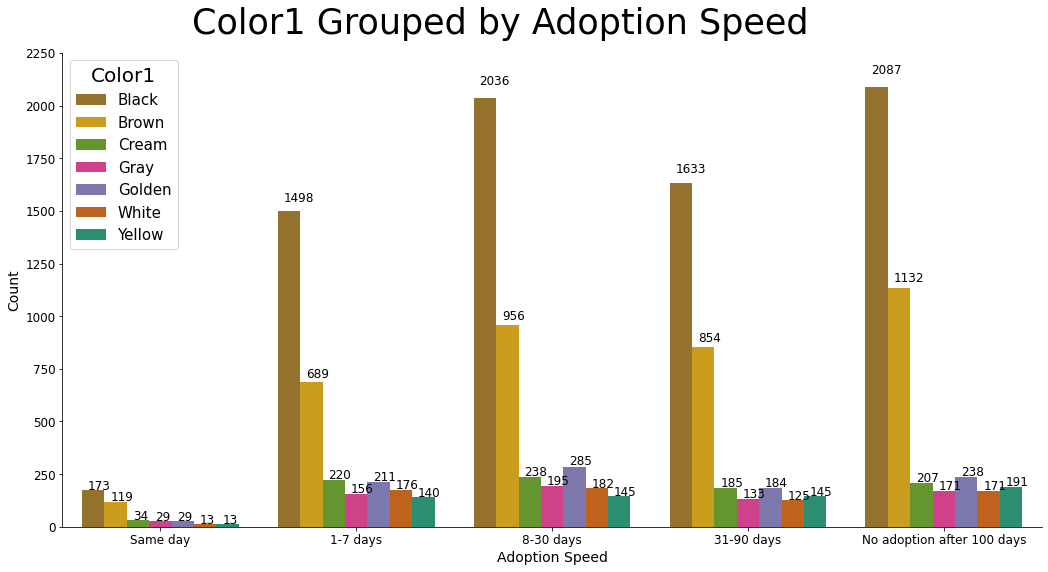

In [ ]:
j = (sns.catplot(data=train, hue="Color1", x="AdoptionSpeed", kind="count", legend=False, palette="Dark2_r")
.set_xticklabels(["Same day", "1-7 days", "8-30 days", "31-90 days", "No adoption after 100 days"], size=12)
.set_yticklabels(size=12))
j.fig.suptitle('Color1 Grouped by Adoption Speed', fontsize=35)
j.fig.subplots_adjust(top=0.9)
j.fig.set_size_inches(16,8)
plt.xlabel("Adoption Speed", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(title="Color1", loc='upper left', fontsize=15, title_fontsize=20)

ax = j.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.03, 
            p.get_height() * 1.03, 
          '{0:.0f}'.format(p.get_height()),   
            color='black', 
            rotation='horizontal', 
            size='large')

Bar charts below and above show pets' color distribution by the adoption speed. We can see that color values are almost proportionally distributed by their shares in ```Color1``` and ```Color2``` features. There seems to be only one exception. Pets with yellow as the first color are more likely to be adopted later (31-90 days) or not adopted at all. However, the assumption could be wrong owing to small data set.

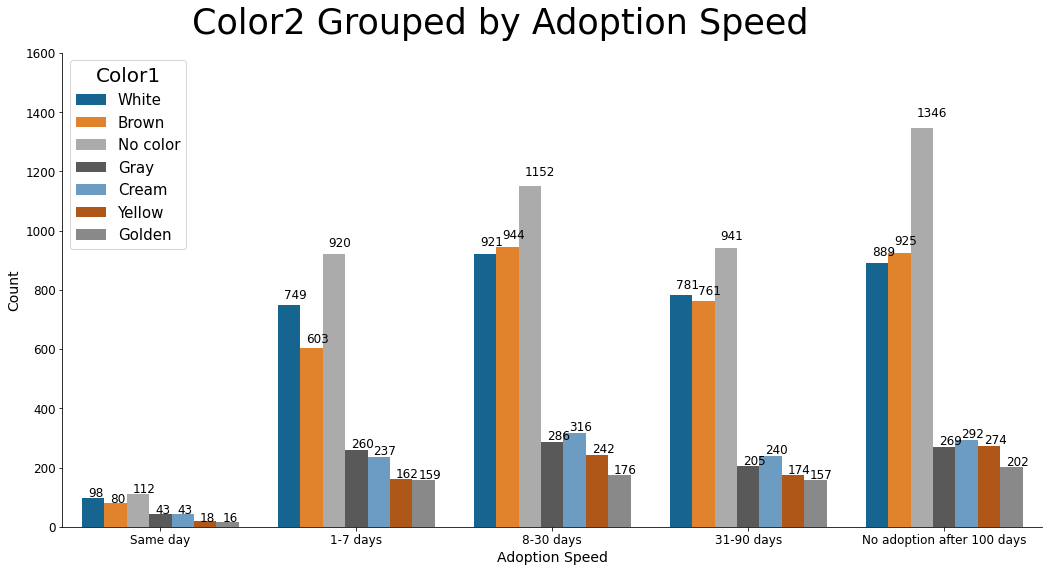

In [ ]:
j = (
    sns.catplot(data=train, hue="Color2", x="AdoptionSpeed", kind="count", legend=False)
    .set_xticklabels(
        [
            "Same day",
            "1-7 days",
            "8-30 days",
            "31-90 days",
            "No adoption after 100 days",
        ],
        size=12,
    )
    .set_yticklabels(size=12)
)
j.fig.suptitle("Color2 Grouped by Adoption Speed", fontsize=35)
j.fig.subplots_adjust(top=0.9)
j.fig.set_size_inches(16, 8)
plt.xlabel("Adoption Speed", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(title="Color1", loc="upper left", fontsize=15, title_fontsize=20)

ax = j.facet_axis(0, 0)
for p in ax.patches:
    ax.text(
        p.get_x() + 0.03,
        p.get_height() * 1.03,
        "{0:.0f}".format(p.get_height()),
        color="black",
        rotation="horizontal",
        size="large",
    )

**Conclusions:**
* Pets with predominant color as yellow are more likely to be adopted later or not at all. Apart from that, color does not seem to impact speed of adoption.

####Health

#####Vaccination

Text(0, 0.5, '')

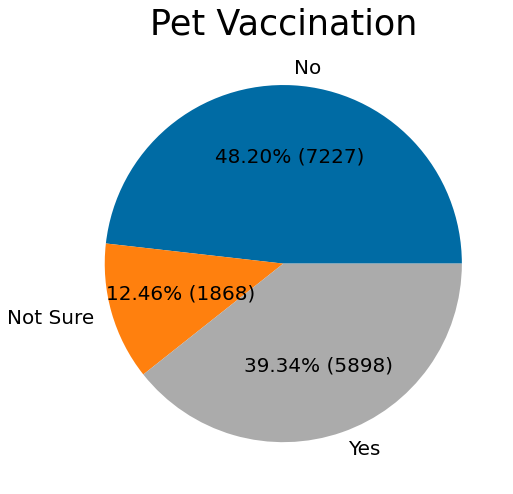

In [ ]:
vaccination = train.groupby("Vaccinated").size()
vaccination.plot(
    kind="pie",
    title="Pet Vaccination",
    autopct=lambda p: "{:.2f}% ({:.0f})".format(p, (p / 100) * vaccination.sum()),
    fontsize=20,
    figsize=(8, 10),
).title.set_size(35)
plt.ylabel("")

According to the pie chart, almost half of all pets for adoption are not vaccinated. Meanwhile, about 40% of pets have received vaccines. The remaining ones (~12 per cent) are not known to be vaccinated or not.

If we look at pet vaccination grouped by adoption speed, we will see that in all columns, but the last one, values are distributed proportionally to the group size in ```Vaccinated``` feature. It is possible that when selecting pet for adoption, owners do not take vaccines into consideration. They could be planning veterinarian appointment for their pet after the adoption in either case. On the other hand, in the last two groups of ```AdoptionSpeed``` the number of vaccinated pets is equal or even larger than that of unvaccinated ones. This pattern is hard to understand and could be influenced by other non-vaccine related factors.

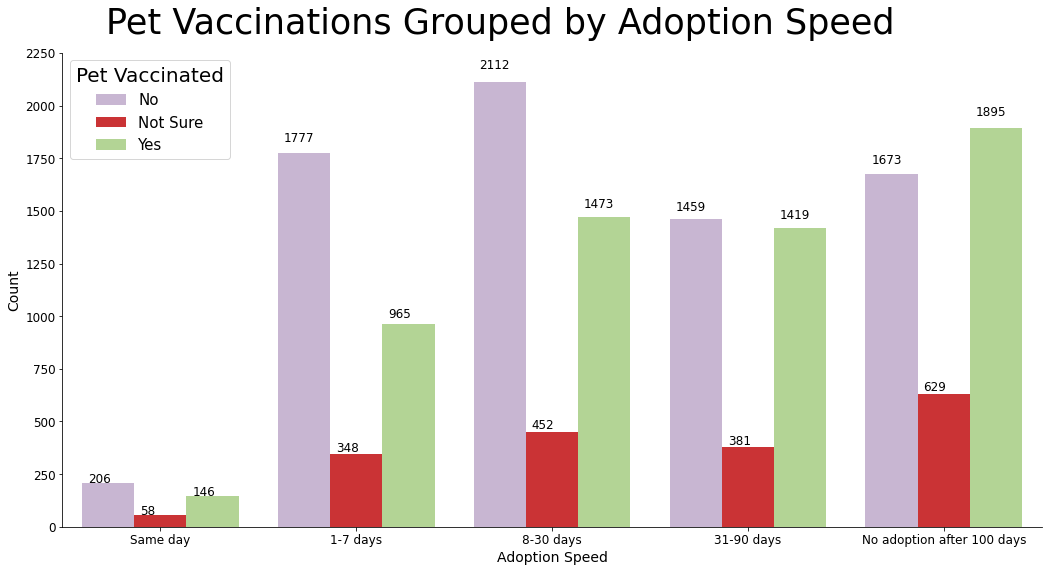

In [ ]:
j = (
    sns.catplot(
        data=train,
        hue="Vaccinated",
        x="AdoptionSpeed",
        kind="count",
        legend=False,
        palette="Paired_r",
    )
    .set_xticklabels(
        [
            "Same day",
            "1-7 days",
            "8-30 days",
            "31-90 days",
            "No adoption after 100 days",
        ],
        size=12,
    )
    .set_yticklabels(size=12)
)
j.fig.suptitle("Pet Vaccinations Grouped by Adoption Speed", fontsize=35)
j.fig.subplots_adjust(top=0.9)
j.fig.set_size_inches(16, 8)
plt.xlabel("Adoption Speed", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(title="Pet Vaccinated", loc="upper left", fontsize=15, title_fontsize=20)

ax = j.facet_axis(0, 0)
for p in ax.patches:
    ax.text(
        p.get_x() + 0.03,
        p.get_height() * 1.03,
        "{0:.0f}".format(p.get_height()),
        color="black",
        rotation="horizontal",
        size="large",
    )

#####Deworming

Text(0, 0.5, '')

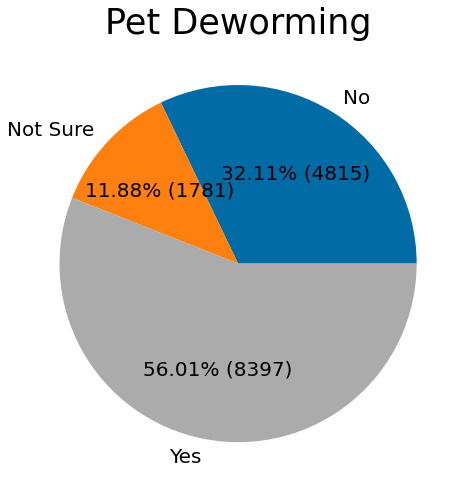

In [ ]:
deworming = train.groupby("Dewormed").size()
deworming.plot(
    kind="pie",
    title="Pet Deworming",
    autopct=lambda p: "{:.2f}% ({:.0f})".format(p, (p / 100) * deworming.sum()),
    fontsize=20,
    figsize=(8, 10),
).title.set_size(35)
plt.ylabel("")

Out of all pets listed in the train data set, more than half (56%) are dewormed (see pie chart above). Similarly, more than a third (32 per cent) of pets for adoption have not gone through deworming procedure. It is unknown whether the remaining (~12%) ones have been dewormed or not. 

When it comes to the preference for dewormed pets, the bar char below does not display any outstanding patterns in adoption speed. It seems that pet owners do not consider deworming as an important characteristic when selecting pets.

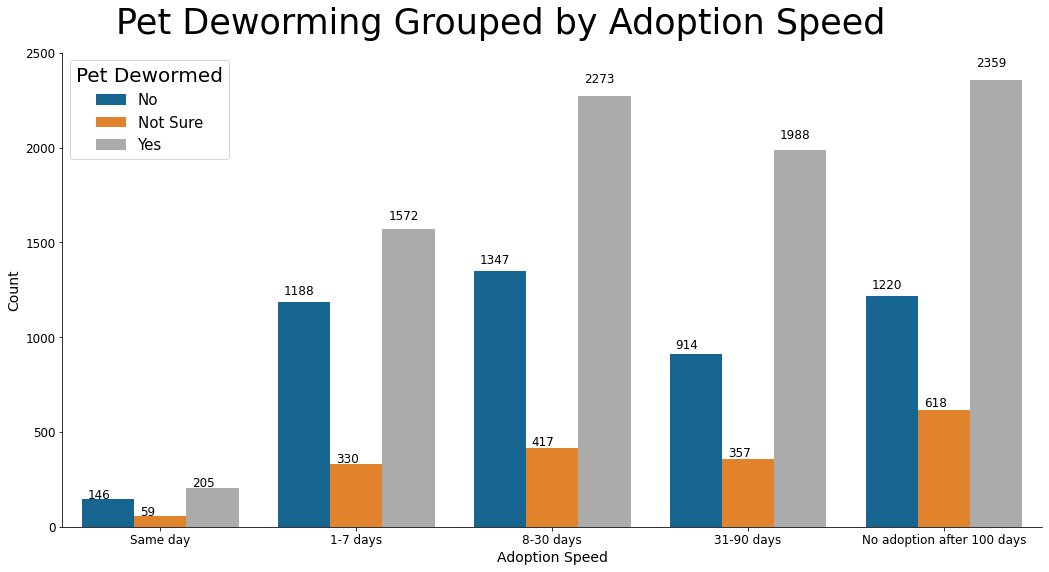

In [ ]:
j = (
    sns.catplot(
        data=train,
        hue="Dewormed",
        x="AdoptionSpeed",
        kind="count",
        legend=False,
    )
    .set_xticklabels(
        [
            "Same day",
            "1-7 days",
            "8-30 days",
            "31-90 days",
            "No adoption after 100 days",
        ],
        size=12,
    )
    .set_yticklabels(size=12)
)
j.fig.suptitle("Pet Deworming Grouped by Adoption Speed", fontsize=35)
j.fig.subplots_adjust(top=0.9)
j.fig.set_size_inches(16, 8)
plt.xlabel("Adoption Speed", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(title="Pet Dewormed", loc="upper left", fontsize=15, title_fontsize=20)

ax = j.facet_axis(0, 0)
for p in ax.patches:
    ax.text(
        p.get_x() + 0.03,
        p.get_height() * 1.03,
        "{0:.0f}".format(p.get_height()),
        color="black",
        rotation="horizontal",
        size="large",
    )

#####Sterilization

Text(0, 0.5, '')

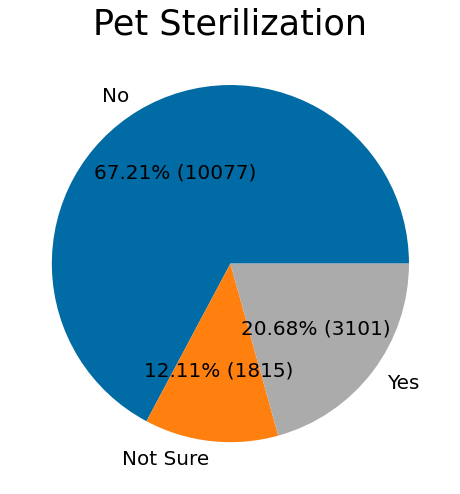

In [ ]:
sterilization = train.groupby("Sterilized").size()
sterilization.plot(
    kind="pie",
    title="Pet Sterilization",
    autopct=lambda p: "{:.2f}% ({:.0f})".format(p, (p / 100) * sterilization.sum()),
    fontsize=20,
    figsize=(8, 10),
).title.set_size(35)
plt.ylabel("")

According to the pie chart above, nearly two thirds (~67%) of listed pets are not sterilized. Only more than 20 per cent of pets for adoption have been neutered. However, similarly to deworming, it doesn't seem that pet sterilization is linked with speedier adoption. Again, it is possible that pet owners plan sterilization after adoption, so they do not prioritize this feature prior adopting a pet.

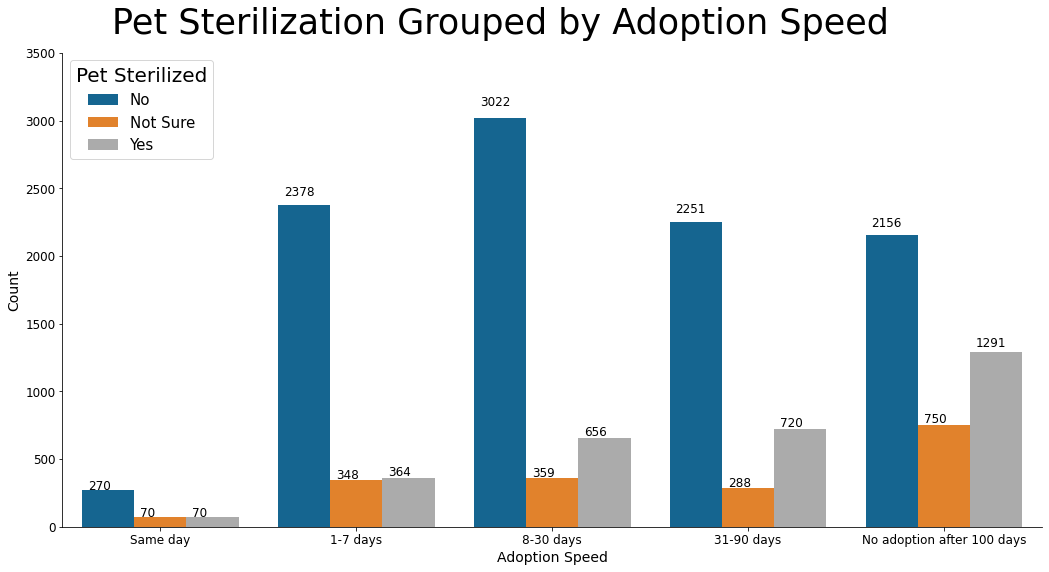

In [ ]:
j = (
    sns.catplot(
        data=train, hue="Sterilized", x="AdoptionSpeed", kind="count", legend=False
    )
    .set_xticklabels(
        [
            "Same day",
            "1-7 days",
            "8-30 days",
            "31-90 days",
            "No adoption after 100 days",
        ],
        size=12,
    )
    .set_yticklabels(size=12)
)
j.fig.suptitle("Pet Sterilization Grouped by Adoption Speed", fontsize=35)
j.fig.subplots_adjust(top=0.9)
j.fig.set_size_inches(16, 8)
plt.xlabel("Adoption Speed", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(title="Pet Sterilized", loc="upper left", fontsize=15, title_fontsize=20)

ax = j.facet_axis(0, 0)
for p in ax.patches:
    ax.text(
        p.get_x() + 0.03,
        p.get_height() * 1.03,
        "{0:.0f}".format(p.get_height()),
        color="black",
        rotation="horizontal",
        size="large",
    )

#####Health

Text(0, 0.5, '')

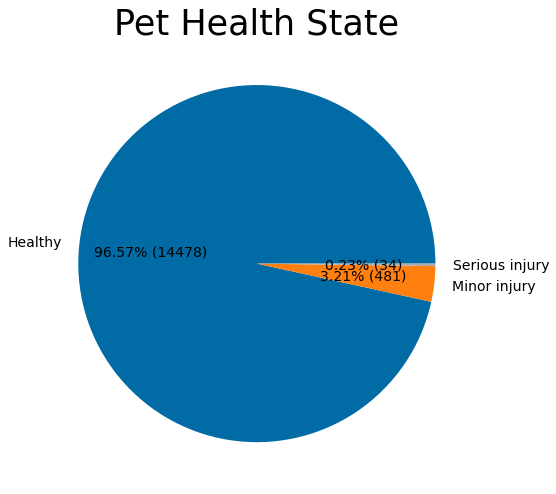

In [ ]:
sterilization = train.groupby("Health").size()
sterilization.plot(
    kind="pie",
    title="Pet Health State",
    autopct=lambda p: "{:.2f}% ({:.0f})".format(p, (p / 100) * sterilization.sum()),
    labels=["Healthy", "Minor injury", "Serious injury"],
    fontsize=14,
    figsize=(8, 10),
).title.set_size(35)
plt.ylabel("")

If we look at pets' health overall state, nearly 97% of all pets in the training data set are healthy (see pie char above). The remaining pets have minor or serious injuries. The grouping by ```AdoptionSpeed``` in the graph below do not show distinct patterns, apart from the observation that there are proportionally more pets with serious injuries not adopted after 100 days.

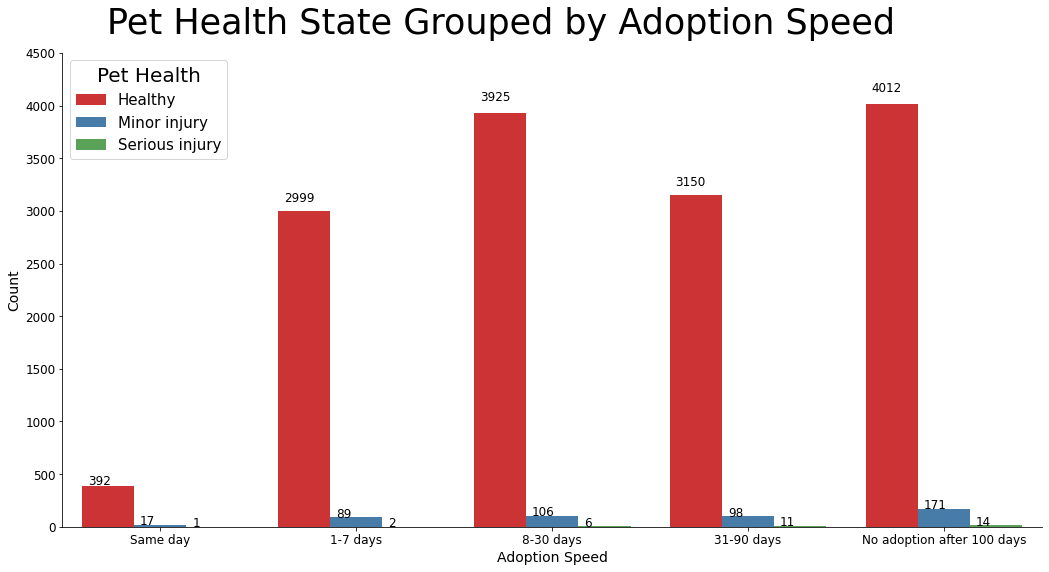

In [ ]:
j = (
    sns.catplot(
        data=train,
        hue="Health",
        x="AdoptionSpeed",
        kind="count",
        legend=False,
        palette="Set1",
    )
    .set_xticklabels(
        [
            "Same day",
            "1-7 days",
            "8-30 days",
            "31-90 days",
            "No adoption after 100 days",
        ],
        size=12,
    )
    .set_yticklabels(size=12)
)
j.fig.suptitle("Pet Health State Grouped by Adoption Speed", fontsize=35)
j.fig.subplots_adjust(top=0.9)
j.fig.set_size_inches(16, 8)
plt.xlabel("Adoption Speed", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(
    title="Pet Health",
    loc="upper left",
    fontsize=15,
    title_fontsize=20,
    labels=["Healthy", "Minor injury", "Serious injury"],
)

ax = j.facet_axis(0, 0)
for p in ax.patches:
    ax.text(
        p.get_x() + 0.03,
        p.get_height() * 1.03,
        "{0:.0f}".format(p.get_height()),
        color="black",
        rotation="horizontal",
        size="large",
    )

**Conclusions**:
* Pet health factors (sterilization, deworming, vaccination and overall health state) do not play noticeable role in the speed of adoption. It is possible that pet owners plan veterinarian visits either way after the adoption, so these factors are not deemed important.
* Pets with serious injuries could be more likely to be not adopted at all, but this could be due to small sample size.

####Other factors

#####Number of pets in profile (Quantity)

Text(0.29999999999999716, 0.5, 'Quantity')

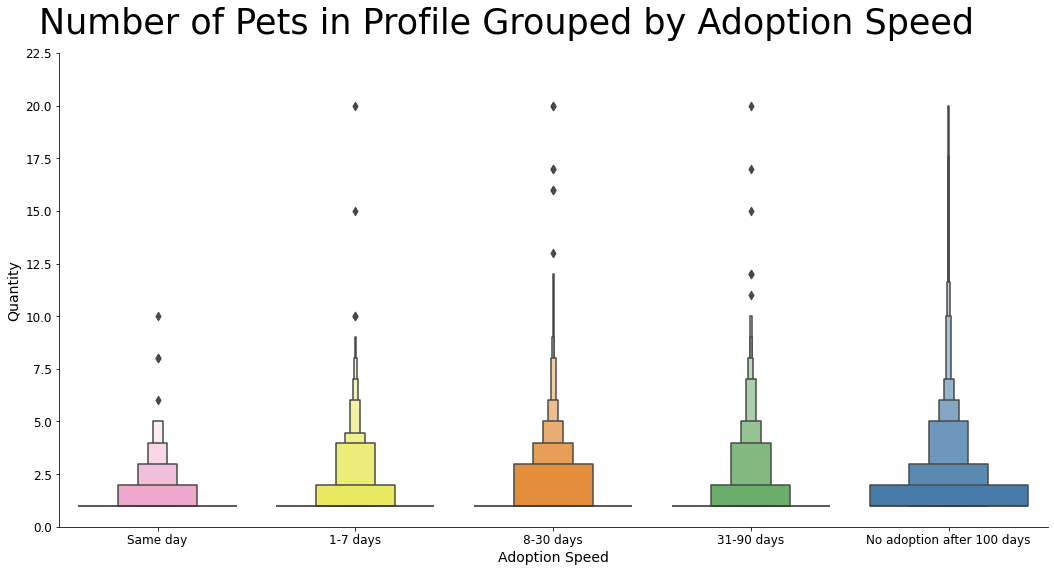

In [ ]:
j = (
    sns.catplot(
        data=train,
        y="Quantity",
        x="AdoptionSpeed",
        kind="boxen",
        legend=False,
        palette="Set1_r",
    )
    .set_xticklabels(
        [
            "Same day",
            "1-7 days",
            "8-30 days",
            "31-90 days",
            "No adoption after 100 days",
        ],
        size=12,
    )
    .set_yticklabels(size=12)
)
j.fig.suptitle("Number of Pets in Profile Grouped by Adoption Speed", fontsize=35)
j.fig.subplots_adjust(top=0.9)
j.fig.set_size_inches(16, 8)
plt.xlabel("Adoption Speed", fontsize=14)
plt.ylabel("Quantity", fontsize=14)

The boxen plot above shows the number of pets (```Quantity```) in each profile grouped by adoption speed. The boxes in each bar represent each quantile, or letter value, and its shape of distribution. With every higher value of ```AdoptionSpeed``` we observe higher letter values, indicating that the higher the quantity of pets in profile, the longer it takes for them to be adopted.

#####Adoption Fee

(0.0, 2000.0)

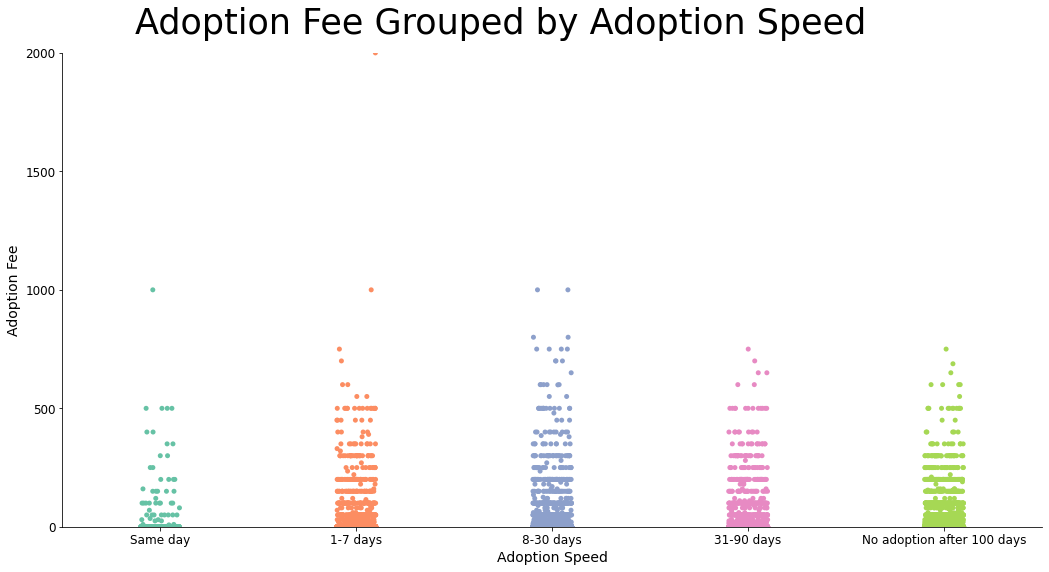

In [ ]:
j = (
    sns.catplot(
        data=train,
        y="Fee",
        x="AdoptionSpeed",
        kind="strip",
        legend=False,
        palette="Set2",
    )
    .set_xticklabels(
        [
            "Same day",
            "1-7 days",
            "8-30 days",
            "31-90 days",
            "No adoption after 100 days",
        ],
        size=12,
    )
    .set_yticklabels(size=12)
)
j.fig.suptitle("Adoption Fee Grouped by Adoption Speed", fontsize=35)
j.fig.subplots_adjust(top=0.9)
j.fig.set_size_inches(16, 8)
plt.xlabel("Adoption Speed", fontsize=14)
plt.ylabel("Adoption Fee", fontsize=14)
plt.ylim(0, 2000)

The swarm plot above displays the distribution of ```Fee``` values along different adoption speeds. No surprisingly, most pets are given away free of charge. Looking at the number of points for each fee category, we can notice how higher adoption fee reduces the speed of adoption. 

Furthermore, although currency is unknown, it would be interesting to visualize how adoption fee changes with breeds. It is possible that pets of popular breeds are more demanded, so they have a higher adoption fee. But this hypothesis is out of this project's theme.

**Conclusions:**
* Higher quantity of pets in profile reduces speed of adoption
* Pets with adoption fee take more time to be adopted.

##Modelling

In this part, I will build 4 ML models: **Random Forest Classifier (RFC)**, **XG Boost Classifier (XGBC)**, **Light Gradient Boosting Classifier (LGBC) ** and **Logistic Regression Classifier (LRC)**. In fact, I had also tried Neural Networks Classifier, Support Vector Classification, RidgeClassifier and K Nearest Neighbor models, but they did not deliver higher kappa scores. 

Firstly, I will use baseline models with no hyperparameter optimization. Then, I will optimize hyperparameters with optuna. Thirdly, I will add ```lang```, ```score```, ```magnitude``` and ```DescriptionLength``` features to the model. Next, I will verify feature importance and afterwards will remove the least important features from the model. At last, I will create synthetic target (```AdoptionSpeed```) values and will train models with balanced train data set before predicting them on test data set. In addition, all models have preprocessor pipelines with SimpleImputer and OneHotEncoder functions. I will scale numerical features only for LRC models. The other 3 algorithms are tree and ensemble ones, so [they do not require scaling for better metrics](https://towardsdatascience.com/do-decision-trees-need-feature-scaling-97809eaa60c6). In fact, I also used StackingClassifier for feature engineering, but it didn't improve scores.

###Preparation for modelling

In [ ]:
# returning data set into initial state
train = pd.read_csv("train/train.csv")

# transforming float PhotoAmt into int
train.PhotoAmt = train.PhotoAmt.astype("int")

In [ ]:
categorical_cols = [
    "Type",
    "Name",
    "Breed1",
    "Breed2",
    "Gender",
    "Color1",
    "Color2",
    "Color3",
    "Vaccinated",
    "Dewormed",
    "Sterilized",
    "State",
    "FurLength",
    "Health",
    "MaturitySize",
]
numerical_cols = ["Quantity", "Fee", "VideoAmt", "PhotoAmt", "Age"]
my_cols = categorical_cols + numerical_cols
target = train.AdoptionSpeed

# preparing pipelines

categorical_transformer = Pipeline(
    steps=[
        ("fill_mode", SimpleImputer(strategy="most_frequent")),
        ("get_dummies", OneHotEncoder(handle_unknown="ignore")),
    ]
)
numerical_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[("for_categories", categorical_transformer, categorical_cols)]
)

preprocessor_lr = ColumnTransformer(
    transformers=[
        ("for_categories", categorical_transformer, categorical_cols),
        ("for_numbers", numerical_transformer, numerical_cols),
    ]
)

### Baseline model from kaggle

#### Random Forest Classifier

In [ ]:
# rfc = RandomForestClassifier(random_state=RANDOM_STATE)
# pipe = Pipeline(
#     steps=[
#         ("feature_engineering", preprocessor),
#         ("model", RandomForestClassifier(random_state=RANDOM_STATE)),
#     ]
# )
# pipe.fit(train[my_cols], target)
# # cross_val_score(pipe, train[my_cols], target, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# pipe.predict(test[my_cols])

In [ ]:
# submission1 = pipe.predict(test[my_cols])
# submission = pd.DataFrame({"PetID": test.PetID, "AdoptionSpeed": submission1})

# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)
# submission.head()

# # cross_val_score = 0.2288813983142198
# # private_score = 0.15657
# # wall time = 281 ms

In [ ]:
baseline = pd.DataFrame(
    data={
        "model": ["RFC"],
        "feature_engineering": ["Baseline"],
        "wall_time_ms": [281],
        "cross_val_score": [0.2288813983142198],
        "private_score": [0.15657],
    }
)

#### XGB Classifier

In [ ]:
# xgbc = XGBClassifier(random_state=RANDOM_STATE, eval_metric=kappa_scorer)
# pipe = Pipeline(steps=[("feature_engineering", preprocessor), ("model", xgbc)])
# pipe.fit(train[my_cols], target)
# # cross_val_score(pipe, train[my_cols], target, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# pipe.predict(test[my_cols])

In [ ]:
# submission1 = pipe.predict(test[my_cols])
# submission = pd.DataFrame({"PetID": test.PetID, "AdoptionSpeed": submission1})

# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)
# submission.head()

# # cross_val_score = 0.2642402885155869
# # private_score = 0.24399
# # wall time = 128 ms

In [ ]:
baseline = baseline.append(
    {
        "model": "XGBC",
        "feature_engineering": "Baseline",
        "wall_time_ms": 128,
        "cross_val_score": 0.2642402885155869,
        "private_score": 0.24399,
    },
    ignore_index=True,
)
baseline

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
0,RFC,Baseline,281,0.228881,0.15657
1,XGBC,Baseline,128,0.264240,0.24399


#### Light Gradient Boosted Machine Classifier

In [ ]:
# lgbc = LGBMClassifier(data_random_seed=RANDOM_STATE)
# pipe = Pipeline(steps=[("feature_engineering", preprocessor), ("model", lgbc)])

# pipe.fit(train[my_cols], target)
# # cross_val_score(pipe, train[my_cols], target, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# pipe.predict(test[my_cols])

In [ ]:
# submission1 = pipe.predict(test[my_cols])
# submission = pd.DataFrame({"PetID": test.PetID, "AdoptionSpeed": submission1})

# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)

# submission.head()
# # cross_val_score = 0.27394114720133667
# # private_score = 0.21905
# # wall time = 112 ms

In [ ]:
# baseline = baseline.append(
#     {
#         "model": "LGBC",
#         "feature_engineering": "Baseline",
#         "wall_time_ms": 112,
#         "cross_val_score": 0.27394114720133667,
#         "private_score": 0.21905,
#     },
#     ignore_index=True,
# )
# baseline

#### Logistic Regression

In [ ]:
# lr = LogisticRegression(random_state=RANDOM_STATE)

# pipe = Pipeline(steps=[("feature_engineering", preprocessor_lr), ("model", lr)])

# pipe.fit(train[my_cols], target)
# # cross_val_score(pipe, train[my_cols], target, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# pipe.predict(test[my_cols])

In [ ]:
# submission1 = pipe.predict(test[my_cols])
# submission = pd.DataFrame({"PetID": test.PetID, "AdoptionSpeed": submission1})

# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)

# submission.head()
# # cross_val_score = 0.2487575181722081
# # private_score = 0.21791
# # wall time = 73.4 ms

In [ ]:
baseline = baseline.append(
    {
        "model": "LRC",
        "feature_engineering": "Baseline",
        "wall_time_ms": 73.4,
        "cross_val_score": 0.2487575181722081,
        "private_score": 0.21791,
    },
    ignore_index=True,
)
baseline

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
0,RFC,Baseline,281.0,0.228881,0.15657
1,XGBC,Baseline,128.0,0.264240,0.24399
2,LRC,Baseline,73.4,0.248758,0.21791


### Optimizing hyperparameters with Optuna




#### RandomForest Classifier with Optuna

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(
#     train[my_cols], target, test_size=0.20, random_state=RANDOM_STATE
# )

# pipe = Pipeline(steps=[("feature_engineering", preprocessor)])
# x_train = pipe.fit_transform(x_train)
# x_test = pipe.transform(x_test)


# def objective(trial):
#     param = {
#         "random_state": RANDOM_STATE,
#         "n_estimators": trial.suggest_int("n_estimators", 1, 1000, log=True),
#         "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
#         "max_depth": trial.suggest_int("max_depth", 2, 30),
#         "max_features": trial.suggest_categorical(
#             "max_features", ["auto", "sqrt", "log2"]
#         ),
#         "min_samples_split": trial.suggest_float(
#             "min_samples_split", 1e-8, 1.0, log=True
#         ),
#         "class_weight": trial.suggest_categorical(
#             "class_weight", ["balanced", "balanced_subsample"]
#         ),
#     }
#     clf = RandomForestClassifier(**param)
#     clf.fit(x_train, y_train)
#     preds = clf.predict(x_test)
#     kappa = cohen_kappa_score(y_test, preds, weights="quadratic")
#     return kappa


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30)
# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)
# print("  Value: {}".format(study.best_trial.value))

In [ ]:
# best_optuna_params_rfc = {
#     "n_estimators": 993,
#     "criterion": "entropy",
#     "max_depth": 29,
#     "max_features": "auto",
#     "min_samples_split": 0.00023537374878089754,
#     "class_weight": "balanced_subsample",
# }
# rfc_optuna = RandomForestClassifier(random_state=RANDOM_STATE, **best_optuna_params_rfc)
# pipe_best = Pipeline(
#     steps=[("feature_engineering", preprocessor), ("model", rfc_optuna)]
# )
# pipe_best.fit(train[my_cols], target)
# # cross_val_score(pipe_best, train[my_cols], target, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# submission1 = pipe_best.predict(test[my_cols])

In [ ]:
# submission = pd.DataFrame({"PetID": test.PetID, "AdoptionSpeed": submission1})
# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)
# submission.head()
# # cross_val_score = 0.2731104459808921
# # private_score = 0.23356
# # wall time = 286 ms

In [ ]:
optuna = pd.DataFrame(
    data={
        "model": ["RFC"],
        "feature_engineering": ["Optuna"],
        "wall_time_ms": [286],
        "cross_val_score": [0.2731104459808921],
        "private_score": [0.23356],
    }
)

#### XGB Classifier with Optuna

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(
#     train[my_cols], target, test_size=0.20, random_state=RANDOM_STATE
# )

# pipe = Pipeline(steps=[("feature_engineering", preprocessor)])
# x_train = pipe.fit_transform(x_train)
# x_test = pipe.transform(x_test)

# train_df = xgb.DMatrix(
#     data=x_train, label=y_train, enable_categorical=True
# )  # , categorical_feature = categorical_cols, free_raw_data=False
# test_df = xgb.DMatrix(data=x_test, label=y_test, enable_categorical=True)


# def objective(trial):
#     param = {
#         "verbosity": 0,
#         "objective": "multi:softmax",
#         "num_class": 5,
#         # defines booster, gblinear for linear functions.
#         "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
#         # L2 regularization weight.
#         "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
#         # L1 regularization weight.
#         "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
#         # sampling ratio for training data.
#         "subsample": trial.suggest_float("subsample", 0.2, 1.0),
#         # sampling according to each tree.
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0),
#     }

#     if param["booster"] in ["gbtree", "dart"]:
#         # maximum depth of the tree, signifies complexity of the tree.
#         param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
#         # minimum child weight, larger the term more conservative the tree.
#         param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
#         param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
#         # defines how selective algorithm is.
#         param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
#         param["grow_policy"] = trial.suggest_categorical(
#             "grow_policy", ["depthwise", "lossguide"]
#         )

#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical(
#             "sample_type", ["uniform", "weighted"]
#         )
#         param["normalize_type"] = trial.suggest_categorical(
#             "normalize_type", ["tree", "forest"]
#         )
#         param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
#         param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

#     xbm = xgb.train(param, train_df)  # ,  early_stopping_rounds=10, num_boost_round=100
#     preds = xbm.predict(test_df)  # , num_iteration=gbm.best_iteration

#     kappa = cohen_kappa_score(y_test, preds, weights="quadratic")
#     return kappa


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30)

# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)
# print("  Value: {}".format(study.best_trial.value))

In [ ]:
# best_params = {
#     "verbosity": 0,
#     "random_state": RANDOM_STATE,
#     "objective": "multi:softmax",
#     "num_class": 5,
#     "booster": "dart",
#     "lambda": 4.208857613754462e-05,
#     "alpha": 3.3117201792138325e-07,
#     "subsample": 0.94972381460606,
#     "colsample_bytree": 0.7523248811626133,
#     "learning_rate": 0.023698890750991686,
#     "max_depth": 5,
#     "min_child_weight": 5,
#     "eta": 0.0005245609920765406,
#     "gamma": 0.0006690589531627338,
#     "grow_policy": "depthwise",
#     "sample_type": "weighted",
#     "normalize_type": "tree",
#     "rate_drop": 0.19384281176622448,
#     "skip_drop": 7.950474838617593e-08,
# }

# best_xgbc = XGBClassifier(**best_params)
# pipe_best = Pipeline(
#     steps=[("feature_engineering", preprocessor), ("model", best_xgbc)]
# )
# pipe_best.fit(train[my_cols], target)

# # cross_val_score(pipe_best, train[my_cols], target, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# submission1 = pipe_best.predict(test[my_cols])

In [ ]:
# submission = pd.DataFrame({"PetID": test.PetID, "AdoptionSpeed": submission1})

# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)

# submission.head()
# # cross_val_score = 0.2458890136465633
# # private_score = 0.21439
# # wall time = 131 ms

In [ ]:
optuna = optuna.append(
    {
        "model": "XGBC",
        "feature_engineering": "Optuna",
        "wall_time_ms": 131,
        "cross_val_score": 0.2458890136465633,
        "private_score": 0.21439,
    },
    ignore_index=True,
)
optuna

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
0,RFC,Optuna,286,0.273110,0.23356
1,XGBC,Optuna,131,0.245889,0.21439


#### Light Gradient Boosted Machine Classifier with Optuna

(kept getting this error: ```TypeError: Unknown type of parameter:boosting_type, got:dict```, so had to use Optuna with LGB model)

In [ ]:
# for col in categorical_cols:
#     train[col] = train[col].astype("category")
#     test[col] = test[col].astype("category")

# x_train, x_test, y_train, y_test = train_test_split(
#     train[my_cols], target, test_size=0.20
# )
# train_df = lgb.Dataset(
#     data=x_train,
#     label=y_train,
#     categorical_feature=categorical_cols,
#     free_raw_data=False,
# )
# test_df = lgb.Dataset(data=x_test, label=y_test, categorical_feature=categorical_cols)


# def objective(trial):
#     param = {
#         "objective": "multiclass",
#         "metric": "multi_logloss",
#         "num_class": 5,
#         "verbosity": -1,
#         "feature_pre_filter": False,
#         "data_random_seed": RANDOM_STATE,
#         "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
#         "num_iterations": trial.suggest_int("num_iterations", 1, 1000),
#         "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
#         "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "max_depth": trial.suggest_int("max_depth", 0, 11),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 1.0),
#         "boosting": trial.suggest_categorical("boosting", ["gbdt", "rf", "dart"]),
#     }

#     gbm = lgb.train(param, train_df, valid_sets=test_df)
#     preds = gbm.predict(x_test).argmax(axis=1)
#     kappa = cohen_kappa_score(y_test, preds, weights="quadratic")
#     return kappa


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30)

# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)
# print("  Value: {}".format(study.best_trial.value))

In [ ]:
# lgbc_best_params = {
#     "objective": "multiclass",
#     "metric": "multi_logloss",
#     "num_class": 5,
#     "verbosity": -1,
#     "feature_pre_filter": False,
#     "data_random_seed": RANDOM_STATE,
#     "lambda_l1": 4.6141117222722105e-06,
#     "num_iterations": 472,
#     "lambda_l2": 8.10908271808845,
#     "num_leaves": 45,
#     "feature_fraction": 0.4140571595220252,
#     "bagging_fraction": 0.777732048698782,
#     "bagging_freq": 2,
#     "min_child_samples": 23,
#     "max_depth": 11,
#     "learning_rate": 0.040281434973799636,
#     "boosting": "gbdt",
# }

# pipe_best = Pipeline(
#     steps=[
#         ("feature_engineering", preprocessor),
#         ("model", LGBMClassifier(**lgbc_best_params)),
#     ]
# )

# pipe_best.fit(train[my_cols], target)
# # cross_val_score(pipe_best, train[my_cols], target, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# submission1 = pipe_best.predict(test[my_cols])

In [ ]:
# submission = pd.DataFrame({"PetID": test.PetID, "AdoptionSpeed": submission1})

# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)

# submission.head()
# # cross_val_score = 0.2741207035942912
# # private_score = 0.24216
# # wall time = 445 ms

In [ ]:
optuna = optuna.append(
    {
        "model": "LGBC",
        "feature_engineering": "Optuna",
        "wall_time_ms": 445,
        "cross_val_score": 0.2741207035942912,
        "private_score": 0.24216,
    },
    ignore_index=True,
)
optuna

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
0,RFC,Optuna,286,0.273110,0.23356
1,XGBC,Optuna,131,0.245889,0.21439
2,LGBC,Optuna,445,0.274121,0.24216


#### Logistic Regression Classifier with Optuna

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(
#     train[my_cols], target, test_size=0.20, random_state=RANDOM_STATE
# )

# pipe = Pipeline(steps=[("feature_engineering", preprocessor_lr)])
# x_train = pipe.fit_transform(x_train)
# x_test = pipe.transform(x_test)


# def objective(trial):
#     param = {
#         "tol": trial.suggest_float("tol", 1e-8, 1.0),
#         "C": trial.suggest_float("C", 1e-8, 5.0),
#         "multi_class": trial.suggest_categorical(
#             "multi_class", ["auto", "ovr"]
#         ),  # , "multinomial"
#         "l1_ratio": trial.suggest_float("l1_ratio", 1e-8, 1.0),
#         "penalty": trial.suggest_categorical(
#             "penalty", ["l1"]
#         ),  # , , "elasticnet", "none"
#         #'solver': trial.suggest_categorical('solver', ["liblinear","saga"])
#     }
#     if param["penalty"] in ["l1"]:
#         param["solver"] = trial.suggest_categorical("solver", ["liblinear", "saga"])

#     #     if param['penalty'] in ["l2"]:
#     #         param['solver'] = trial.suggest_categorical('solver', ["newton-cg", "sag", "lbfgs"])

#     #     if param['penalty'] in ["elasticnet"]:
#     #         param['solver'] = trial.suggest_categorical('solver', ["saga"])

#     #     if param['penalty'] in ["none"]:
#     #         param['solver'] = trial.suggest_categorical('solver', ["newton-cg", "lbfgs", "sag", "saga"])

#     clf = LogisticRegression(**param, random_state=RANDOM_STATE)
#     clf.fit(x_train, y_train)
#     preds = clf.predict(x_test)
#     kappa = cohen_kappa_score(y_test, preds, weights="quadratic")
#     return kappa


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50)
# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)
# print("  Value: {}".format(study.best_trial.value))

In [ ]:
# param_l1 = {
#     "random_state": RANDOM_STATE,
#     "tol": 0.026613150485841983,
#     "C": 1.058157153447051,
#     "multi_class": "auto",
#     "penalty": "l1",
#     "solver": "saga",
#     "l1_ratio": 0.23531118760981812,
# }  #

# param_l2 = {
#     "random_state": RANDOM_STATE,
#     "tol": 0.6200960876607317,
#     "C": 0.12967398710567807,
#     "multi_class": "multinomial",
#     "l1_ratio": 0.23930428415373572,
#     "penalty": "l2",
#     "solver": "newton-cg",
# }

# param_elasticnet = {
#     "random_state": RANDOM_STATE,
#     "tol": 0.07732146821605572,
#     "C": 0.5599485441132039,
#     "multi_class": "auto",
#     "l1_ratio": 0.895862655196986,
#     "penalty": "elasticnet",
#     "solver": "saga",
# }

# param_none = {
#     "random_state": RANDOM_STATE,
#     "tol": 0.10352355853326661,
#     "C": 0.003640692717328694,
#     "multi_class": "ovr",
#     "l1_ratio": 0.006221332170005298,
#     "penalty": "none",
#     "solver": "saga",
# }

# pipe = Pipeline(
#     steps=[
#         ("feature_engineering", preprocessor),
#         ("model", LogisticRegression(**param_l1)),
#     ]
# )
# pipe.fit(train[my_cols], target)

# # cross_val_score(pipe, train, target, target, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# submission1 = pipe.predict(test[my_cols])

In [ ]:
# submission = pd.DataFrame({"PetID": test.PetID, "AdoptionSpeed": submission1})

# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)
# submission.head()

# # l1: crossval 0.2341241308238103 67.9 ms 0.20183
# # l2: crossval 0.2506563381843834 67.9 ms 0.17613
# # elasticnet: crossval 0.22682167121650904 68.4 ms 0.17997
# # none: crossval 0.20299102473605224 67.1 ms 0.18351

In [ ]:
optuna = optuna.append(
    {
        "model": "LRC",
        "feature_engineering": "Optuna",
        "wall_time_ms": 67.9,
        "cross_val_score": 0.2341241308238103,
        "private_score": 0.20183,
    },
    ignore_index=True,
)
optuna

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
0,RFC,Optuna,286.0,0.273110,0.23356
1,XGBC,Optuna,131.0,0.245889,0.21439
2,LGBC,Optuna,445.0,0.274121,0.24216
3,LRC,Optuna,67.9,0.234124,0.20183


In [ ]:
optuna_lr = pd.DataFrame(
    {
        "model": ["LRC_l1", "LRC_l2", "LRC_elasticnet", "LRC_none"],
        "feature_engineering": ["Optuna", "Optuna", "Optuna", "Optuna"],
        "wall_time_ms": [67.9, 67.9, 68.4, 67.1],
        "cross_val_score": [
            0.2341241308238103,
            0.2506563381843834,
            0.22682167121650904,
            0.20299102473605224,
        ],
        "private_score": [0.20183, 0.17613, 0.17997, 0.18351],
    }
)
optuna_lr

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
0,LRC_l1,Optuna,67.9,0.234124,0.20183
1,LRC_l2,Optuna,67.9,0.250656,0.17613
2,LRC_elasticnet,Optuna,68.4,0.226822,0.17997
3,LRC_none,Optuna,67.1,0.202991,0.18351


### Adding sentimental data and DescriptionLength

#### Preprocessing data

In [ ]:
# creating new feature DescriptionLength
train_sentimental["DescriptionLength"] = (
    train_sentimental["Description"].str.split().str.len().fillna(0.0).astype(int)
)
test_sentimental["DescriptionLength"] = (
    test_sentimental["Description"].str.split().str.len().fillna(0.0).astype(int)
)

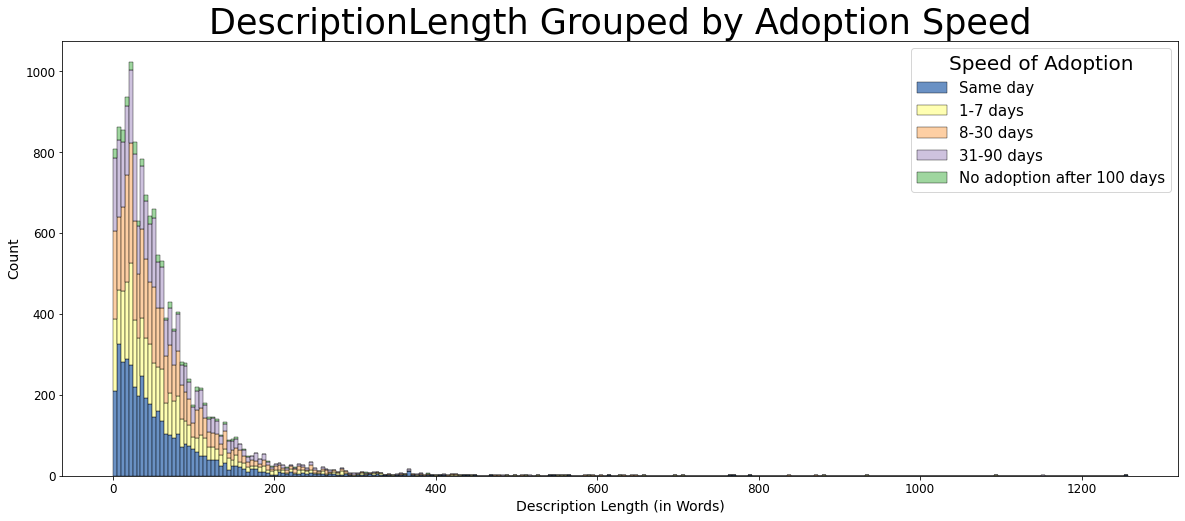

In [ ]:
plt.figure(figsize=(20, 8))
g = sns.histplot(
    data=train_sentimental,
    x="DescriptionLength",
    multiple="stack",
    hue="AdoptionSpeed",
    palette="Accent",
)
g.set_title("DescriptionLength Grouped by Adoption Speed", fontsize=35)
g.set_xlabel("Description Length (in Words)", fontsize=14)
g.set_ylabel("Count", fontsize=14)
g.tick_params(labelsize=12)
plt.legend(
    title="Speed of Adoption",
    loc="upper right",
    fontsize=15,
    title_fontsize=20,
    labels=[
        "Same day",
        "1-7 days",
        "8-30 days",
        "31-90 days",
        "No adoption after 100 days",
    ],
)

As we see, most pet descriptions have 0-100 word length.

In [ ]:
train_sentimental.lang.value_counts(normalize=True)

en         0.954379
no         0.036750
zh         0.006336
zh-Hant    0.002401
de         0.000133
Name: lang, dtype: float64

More than 95% of pet descriptions are in English. 

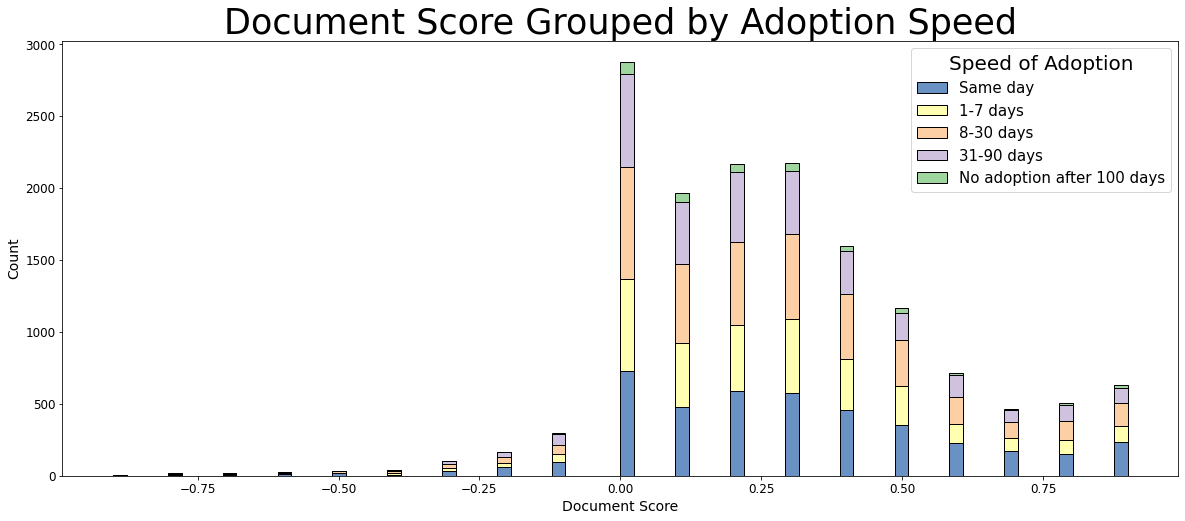

In [ ]:
plt.figure(figsize=(20, 8))
g = sns.histplot(
    data=train_sentimental,
    x="score",
    multiple="stack",
    hue="AdoptionSpeed",
    palette="Accent",
)
g.set_title("Document Score Grouped by Adoption Speed", fontsize=35)
g.set_xlabel("Document Score", fontsize=14)
g.set_ylabel("Count", fontsize=14)
g.tick_params(labelsize=12)
plt.legend(
    title="Speed of Adoption",
    loc="upper right",
    fontsize=15,
    title_fontsize=20,
    labels=[
        "Same day",
        "1-7 days",
        "8-30 days",
        "31-90 days",
        "No adoption after 100 days",
    ],
)

Interestingly, there are very few ```score``` observations below 0. Most values are in the range 0 - 0.5.

<Figure size 1440x576 with 0 Axes>

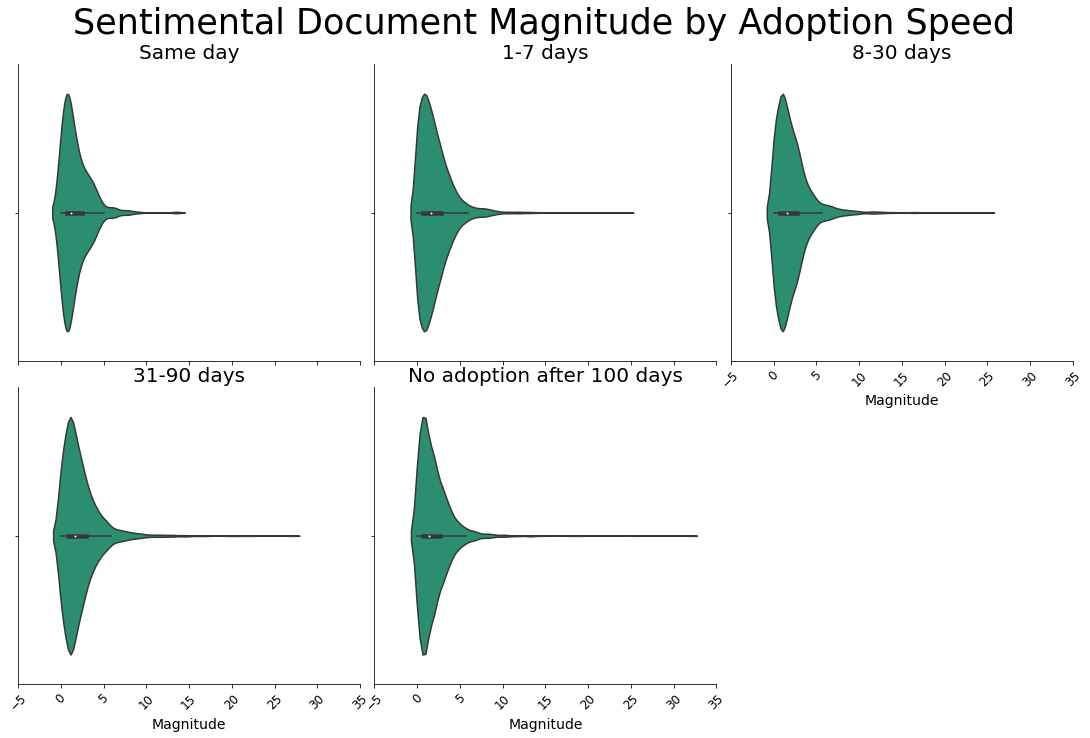

In [ ]:
plt.figure(figsize=(20, 8))
h = (
    sns.catplot(
        data=train_sentimental,
        x="magnitude",
        col="AdoptionSpeed",
        col_wrap=3,
        kind="violin",
        palette="Dark2",
        scale="count",
    )
    .set_axis_labels("Magnitude", "", size=14)
    .set_xticklabels(rotation=45, size=12)
)
h.fig.subplots_adjust(top=0.9)
h.fig.suptitle("Sentimental Document Magnitude by Adoption Speed", fontsize=35)

labels = [
    "Same day",
    "1-7 days",
    "8-30 days",
    "31-90 days",
    "No adoption after 100 days",
]
axes = h.axes.flatten()
for i, label in enumerate(labels):
    axes[i].set_title(f"{label}", fontsize=20)

Across 5 levels of speed of adoption, ```magnitude``` stack around 2. Moreover, higher magnitude values correlate with lower speed of adoption.

In [ ]:
categorical_cols = [
    "Type",
    "Name",
    "Breed1",
    "Breed2",
    "Gender",
    "Color1",
    "Color2",
    "Color3",
    "Vaccinated",
    "Dewormed",
    "Sterilized",
    "State",
    "FurLength",
    "Health",
    "MaturitySize",
    "lang",
]
numerical_cols = [
    "Quantity",
    "Fee",
    "VideoAmt",
    "PhotoAmt",
    "Age",
    "score",
    "magnitude",
    "DescriptionLength",
]
my_cols = categorical_cols + numerical_cols
target = train_sentimental.AdoptionSpeed

categorical_transformer = Pipeline(
    steps=[
        ("fill_mode", SimpleImputer(strategy="most_frequent")),
        ("get_dummies", OneHotEncoder(handle_unknown="ignore")),
    ]
)
numerical_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("for_categories", categorical_transformer, categorical_cols),
    ]
)

preprocessor_lr = ColumnTransformer(
    transformers=[
        ("for_categories", categorical_transformer, categorical_cols),
        ("for_numbers", numerical_transformer, numerical_cols),
    ]
)

#### Random Forest Classifier + Optuna +Sentimental data and DescriptionLength

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(
#     train_sentimental[my_cols], target, test_size=0.20, random_state=RANDOM_STATE
# )

# pipe = Pipeline(steps=[("feature_engineering", preprocessor)])
# x_train = pipe.fit_transform(x_train)
# x_test = pipe.transform(x_test)


# def objective(trial):
#     param = {
#         "random_state": RANDOM_STATE,
#         "n_estimators": trial.suggest_int("n_estimators", 1, 1000, log=True),
#         "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
#         "max_depth": trial.suggest_int("max_depth", 2, 30),
#         "max_features": trial.suggest_categorical(
#             "max_features", ["auto", "sqrt", "log2"]
#         ),
#         "min_samples_split": trial.suggest_float(
#             "min_samples_split", 1e-8, 1.0, log=True
#         ),
#         "class_weight": trial.suggest_categorical(
#             "class_weight", ["balanced", "balanced_subsample"]
#         ),
#     }
#     clf = RandomForestClassifier(**param)
#     clf.fit(x_train, y_train)
#     preds = clf.predict(x_test)
#     kappa = cohen_kappa_score(y_test, preds, weights="quadratic")
#     return kappa


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30)
# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)
# print("  Value: {}".format(study.best_trial.value))

In [ ]:
# best_optuna_params_rfc = {
#     "n_estimators": 391,
#     "criterion": "gini",
#     "max_depth": 30,
#     "max_features": "sqrt",
#     "min_samples_split": 1.4608734815184067e-06,
#     "class_weight": "balanced_subsample",
# }

# rfc_optuna = RandomForestClassifier(random_state=RANDOM_STATE, **best_optuna_params_rfc)
# pipe_best = Pipeline(
#     steps=[("feature_engineering", preprocessor), ("model", rfc_optuna)]
# )
# pipe_best.fit(train_sentimental[my_cols], target)
# # cross_val_score(pipe_best, train_sentimental[my_cols], target, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# submission1 = pipe_best.predict(test_sentimental[my_cols])

In [ ]:
# submission = pd.DataFrame(
#     {"PetID": test_sentimental.PetID, "AdoptionSpeed": submission1}
# )
# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)
# submission.head()
# # cross_val_score = 0.276332396410018
# # private_score = 0.20578
# # wall time = 428 ms

In [ ]:
more_data = pd.DataFrame(
    data={
        "model": ["RFC"],
        "feature_engineering": ["Features added"],
        "wall_time_ms": [428],
        "cross_val_score": [0.276332396410018],
        "private_score": [0.20578],
    }
)
more_data

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
0,RFC,Features added,428,0.276332,0.20578


#### XGBClassifier + Sentimental data + Optuna and DescriptionLength

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(
#     train_sentimental[my_cols], target, test_size=0.20, random_state=RANDOM_STATE
# )

# pipe = Pipeline(steps=[("feature_engineering", preprocessor)])
# x_train = pipe.fit_transform(x_train)
# x_test = pipe.transform(x_test)

# train_df = xgb.DMatrix(
#     data=x_train, label=y_train, enable_categorical=True
# )  # , categorical_feature = categorical_cols, free_raw_data=False
# test_df = xgb.DMatrix(data=x_test, label=y_test, enable_categorical=True)


# def objective(trial):
#     param = {
#         "verbosity": 0,
#         "objective": "multi:softmax",
#         "num_class": 5,
#         # defines booster, gblinear for linear functions.
#         "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
#         # L2 regularization weight.
#         "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
#         # L1 regularization weight.
#         "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
#         # sampling ratio for training data.
#         "subsample": trial.suggest_float("subsample", 0.2, 1.0),
#         # sampling according to each tree.
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0),
#     }

#     if param["booster"] in ["gbtree", "dart"]:
#         # maximum depth of the tree, signifies complexity of the tree.
#         param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
#         # minimum child weight, larger the term more conservative the tree.
#         param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
#         param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
#         # defines how selective algorithm is.
#         param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
#         param["grow_policy"] = trial.suggest_categorical(
#             "grow_policy", ["depthwise", "lossguide"]
#         )

#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical(
#             "sample_type", ["uniform", "weighted"]
#         )
#         param["normalize_type"] = trial.suggest_categorical(
#             "normalize_type", ["tree", "forest"]
#         )
#         param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
#         param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

#     xbm = xgb.train(param, train_df)  # ,  early_stopping_rounds=10, num_boost_round=100
#     preds = xbm.predict(test_df)  # , num_iteration=gbm.best_iteration

#     kappa = cohen_kappa_score(y_test, preds, weights="quadratic")
#     return kappa


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)
# print("  Value: {}".format(study.best_trial.value))

In [ ]:
# xgbc_params = {
#     "random_state": RANDOM_STATE,
#     "eval_metric": kappa_scorer,
#     "booster": "gbtree",
#     "lambda": 0.00010062265883696633,
#     "alpha": 0.05549415742460419,
#     "subsample": 0.9548731970845955,
#     "colsample_bytree": 0.8291027131574082,
#     "learning_rate": 0.24635389915020683,
#     "max_depth": 5,
#     "min_child_weight": 3,
#     "eta": 0.042641520557783835,
#     "gamma": 3.964109321975704e-05,
#     "grow_policy": "lossguide",
# }
# xgbc = XGBClassifier(**xgbc_params)
# pipe = Pipeline(steps=[("feature_engineering", preprocessor), ("model", xgbc)])
# pipe.fit(train_sentimental[my_cols], target)
# # cross_val_score(pipe, train_sentimental[my_cols], target, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# submission1 = pipe.predict(test_sentimental[my_cols])

In [ ]:
# submission = pd.DataFrame(
#     {"PetID": test_sentimental.PetID, "AdoptionSpeed": submission1}
# )

# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)
# submission.head()

# # cross_val_score = 0.2711910515471382
# # private_score = 0.20608
# # wall time = 121 ms

In [ ]:
more_data = more_data.append(
    {
        "model": "XGBC",
        "feature_engineering": "Features added",
        "wall_time_ms": 121,
        "cross_val_score": 0.2711910515471382,
        "private_score": 0.20608,
    },
    ignore_index=True,
)
more_data

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
0,RFC,Features added,428,0.276332,0.20578
1,XGBC,Features added,121,0.271191,0.20608


#### LGB Classifier + Sentimental data + Optuna and DescriptionLength

In [ ]:
# for col in categorical_cols:
#     train_sentimental[col] = train_sentimental[col].astype("category")
#     test_sentimental[col] = test_sentimental[col].astype("category")

# x_train, x_test, y_train, y_test = train_test_split(
#     train_sentimental[my_cols], target, test_size=0.20
# )
# train_df = lgb.Dataset(
#     data=x_train,
#     label=y_train,
#     categorical_feature=categorical_cols,
#     free_raw_data=False,
# )
# test_df = lgb.Dataset(data=x_test, label=y_test, categorical_feature=categorical_cols)


# def objective(trial):
#     param = {
#         "objective": "multiclass",
#         "metric": "multi_logloss",
#         "num_class": 5,
#         "verbosity": -1,
#         "feature_pre_filter": False,
#         "data_random_seed": RANDOM_STATE,
#         "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
#         "num_iterations": trial.suggest_int("num_iterations", 1, 1000),
#         "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
#         "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "max_depth": trial.suggest_int("max_depth", 0, 11),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 1.0),
#         "boosting": trial.suggest_categorical("boosting", ["gbdt", "rf", "dart"]),
#     }

#     gbm = lgb.train(param, train_df, valid_sets=test_df, verbose_eval=False)
#     preds = gbm.predict(x_test).argmax(axis=1)
#     kappa = cohen_kappa_score(y_test, preds, weights="quadratic")
#     return kappa


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)
# print("  Value: {}".format(study.best_trial.value))

In [ ]:
# lgbc_best_params = {
#     "objective": "multiclass",
#     "metric": "multi_logloss",
#     "num_class": 5,
#     "verbosity": -1,
#     "feature_pre_filter": False,
#     "data_random_seed": RANDOM_STATE,
#     "lambda_l1": 0.00023142355871438668,
#     "num_iterations": 604,
#     "lambda_l2": 9.05869964473416,
#     "num_leaves": 201,
#     "feature_fraction": 0.8928400895713848,
#     "bagging_fraction": 0.6087690667875485,
#     "bagging_freq": 1,
#     "min_child_samples": 37,
#     "max_depth": 9,
#     "learning_rate": 0.06196672552061311,
#     "boosting": "dart",
# }

# pipe_best = Pipeline(
#     steps=[
#         ("feature_engineering", preprocessor),
#         ("model", LGBMClassifier(**lgbc_best_params)),
#     ]
# )

# pipe_best.fit(train_sentimental[my_cols], target)
# # cross_val_score(pipe_best, train_sentimental, target, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# submission1 = pipe_best.predict(test_sentimental[my_cols])

In [ ]:
# submission = pd.DataFrame(
#     {"PetID": test_sentimental.PetID, "AdoptionSpeed": submission1}
# )

# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)
# submission.head()

# # cross_val_score = 0.27767935779859615
# # private_score = 0.20642
# # wall time = 432 ms

In [ ]:
more_data = more_data.append(
    {
        "model": "LGBC",
        "feature_engineering": "Features added",
        "wall_time_ms": 432,
        "cross_val_score": 0.27767935779859615,
        "private_score": 0.20642,
    },
    ignore_index=True,
)
more_data

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
0,RFC,Features added,428,0.276332,0.20578
1,XGBC,Features added,121,0.271191,0.20608
2,LGBC,Features added,432,0.277679,0.20642


#### Logistic Regression + Optuna + Sentimental data and DescriptionLength

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(
#     train_sentimental[my_cols], target, test_size=0.20, random_state=RANDOM_STATE
# )

# pipe = Pipeline(steps=[("feature_engineering", preprocessor)])
# x_train = pipe.fit_transform(x_train)
# x_test = pipe.transform(x_test)


# def objective(trial):
#     param = {
#         "tol": trial.suggest_float("tol", 1e-8, 1.0),
#         "C": trial.suggest_float("C", 1e-8, 5.0),
#         "multi_class": trial.suggest_categorical(
#             "multi_class", ["auto", "ovr", "multinomial"]
#         ),
#         "l1_ratio": trial.suggest_float("l1_ratio", 1e-8, 1.0),
#         "penalty": trial.suggest_categorical(
#             "penalty", ["elasticnet"]
#         ),  # , , "elasticnet", "none"
#         #'solver': trial.suggest_categorical('solver', ["liblinear","saga"])
#     }
#     #     if param['penalty'] in ["l1"]:
#     #         param['solver'] = trial.suggest_categorical('solver', ["liblinear","saga"])

#     #     if param['penalty'] in ["l2"]:
#     #         param['solver'] = trial.suggest_categorical('solver', ["newton-cg", "sag", "lbfgs"])

            # if param["penalty"] in ["elasticnet"]:
            #     param["solver"] = trial.suggest_categorical("solver", ["saga"])

#     #     if param['penalty'] in ["none"]:
#     #         param['solver'] = trial.suggest_categorical('solver', ["newton-cg", "lbfgs", "sag", "saga"])

#     clf = LogisticRegression(**param, random_state=RANDOM_STATE)
#     clf.fit(x_train, y_train)
#     preds = clf.predict(x_test)
#     kappa = cohen_kappa_score(y_test, preds, weights="quadratic")
#     return kappa


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)
# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)
# print("  Value: {}".format(study.best_trial.value))

In [ ]:
# param_l1 = {
#     "random_state": RANDOM_STATE,
#     "tol": 0.055240406696098476,
#     "C": 0.6017854296897203,
#     "multi_class": "ovr",
#     "l1_ratio": 0.5004024802530747,
#     "penalty": "l1",
#     "solver": "saga",
# }

# param_l2 = {
#     "random_state": RANDOM_STATE,
#     "tol": 0.3537662041540821,
#     "C": 0.11617573832867531,
#     "multi_class": "ovr",
#     "l1_ratio": 0.303133776732768,
#     "penalty": "l2",
#     "solver": "sag",
# }

# param_elasticnet = {
#     "random_state": RANDOM_STATE,
#     "tol": 0.0794109797957146,
#     "C": 4.225643962140985,
#     "multi_class": "auto",
#     "l1_ratio": 0.5740807784868983,
#     "penalty": "elasticnet",
#     "solver": "saga",
# }

# param_none = {
#     "random_state": RANDOM_STATE,
#     "tol": 0.06894321397244152,
#     "C": 0.6833731798979652,
#     "multi_class": "multinomial",
#     "l1_ratio": 0.8403301211851364,
#     "penalty": "none",
#     "solver": "saga",
# }
# pipe = Pipeline(
#     steps=[
#         ("feature_engineering", preprocessor),
#         ("model", LogisticRegression(**param_l1)),
#     ]
# )
# pipe.fit(train_sentimental[my_cols], target)

# # cross_val_score(pipe, train_sentimental, target, target, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# submission1 = pipe.predict(test_sentimental[my_cols])

In [ ]:
# submission = pd.DataFrame({"PetID": test.PetID, "AdoptionSpeed": submission1})

# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)
# submission.head()

# # l1: crossval 0.25148386876594325 71.8 ms 0.22519
# # l2: crossval 0.22857818155463844 73.3 ms 0.21465
# # elasticnet: crossval 0.24022113009128584 68.5 ms 0.19944
# # none: crossval 0.22821958236179993 72.5 ms 0.20040

In [ ]:
more_data = more_data.append(
    {
        "model": "LRC",
        "feature_engineering": "Features added",
        "wall_time_ms": 71.8,
        "cross_val_score": 0.25148386876594325,
        "private_score": 0.22519,
    },
    ignore_index=True,
)
more_data

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
0,RFC,Features added,428.0,0.276332,0.20578
1,XGBC,Features added,121.0,0.271191,0.20608
2,LGBC,Features added,432.0,0.277679,0.20642
3,LRC,Features added,71.8,0.251484,0.22519


### Feature Importance

#### LGB Classifier with sentimental data for feature importance

In [ ]:
for col in categorical_cols:
    train_sentimental[col] = train_sentimental[col].astype("category")
    test_sentimental[col] = test_sentimental[col].astype("category")

In [ ]:
lgbc_best_params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 5,
    "verbosity": -1,
    "feature_pre_filter": False,
    "data_random_seed": RANDOM_STATE,
    "lambda_l1": 1.316622790539657e-06,
    "num_iterations": 432,
    "lambda_l2": 0.6056333648950022,
    "num_leaves": 75,
    "feature_fraction": 0.7815432035719809,
    "bagging_fraction": 0.7950809721083675,
    "bagging_freq": 7,
    "min_child_samples": 40,
    "max_depth": 9,
    "learning_rate": 0.029217003388914968,
    "boosting": "dart",
}


best_lgbc = lgb.LGBMClassifier(**lgbc_best_params)
best_lgbc.fit(train_sentimental[my_cols], target)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



LGBMClassifier(bagging_fraction=0.7950809721083675, bagging_freq=7,
        boosting='dart', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, data_random_seed=8,
        feature_fraction=0.7815432035719809, feature_pre_filter=False,
        importance_type='split', lambda_l1=1.316622790539657e-06,
        lambda_l2=0.6056333648950022, learning_rate=0.029217003388914968,
        max_depth=9, metric='multi_logloss', min_child_samples=40,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_class=5, num_iterations=432, num_leaves=75,
        objective='multiclass', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

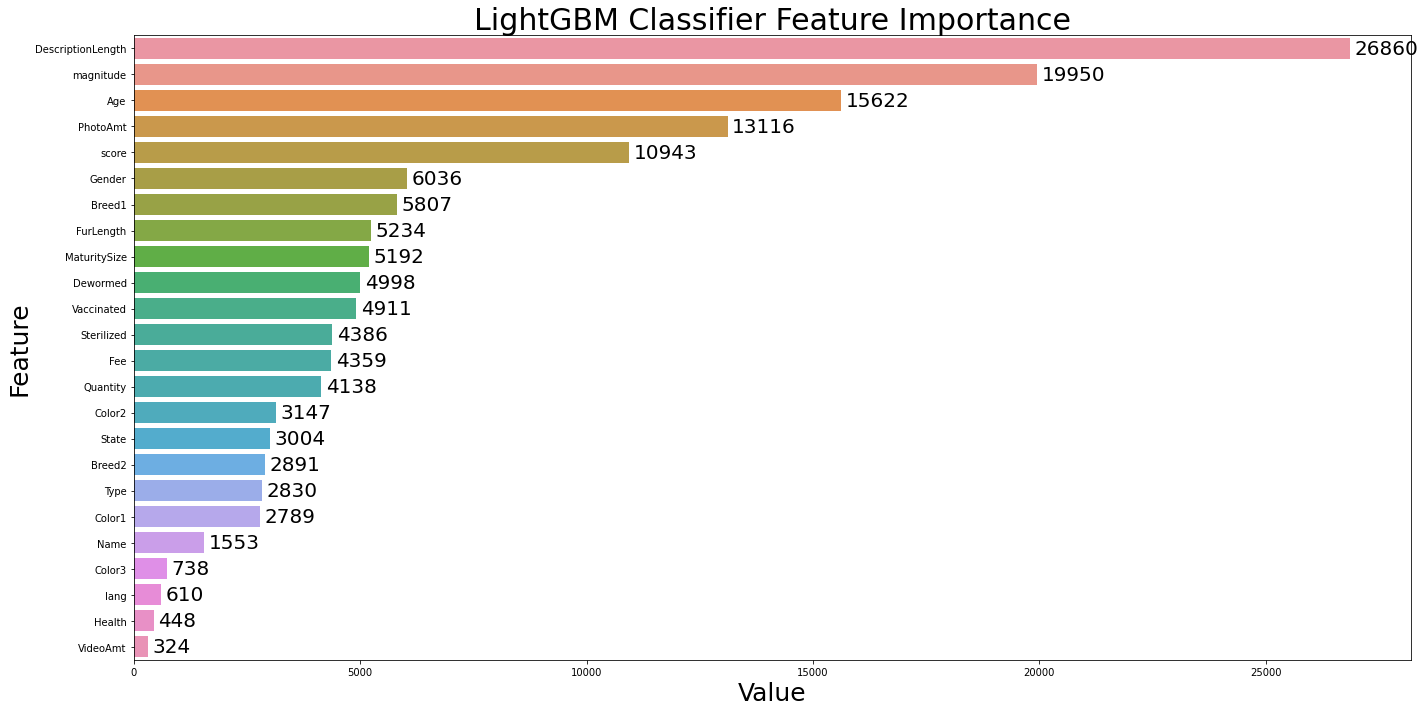

In [ ]:
feature_imp = pd.DataFrame(
    {
        "Value": best_lgbc.feature_importances_,
        "Feature": train_sentimental[my_cols].columns,
    }
)
feature_imp.sort_values(by="Value", ascending=False)
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)
)
for p in ax.patches:
    width = p.get_width()  # get bar length
    ax.text(
        width + 100,  # set the text at 1 unit right of the bar
        p.get_y() + p.get_height() / 2,  # get Y coordinate + X coordinate / 2
        "{:1.0f}".format(width),  # set variable to display
        ha="left",  # horizontal alignment
        va="center", # vertical alignment
        fontsize=20,
    )  

plt.title("LightGBM Classifier Feature Importance", fontsize=30)
plt.xlabel("Value", fontsize=25)
plt.ylabel("Feature", fontsize=25)
plt.tight_layout()
plt.show()

According to the barplot, 4 features have relatively little importance: ```Color3, Health, VideoAmt``` and ```lang```. I'm going to remove them from future models sets and see, if if improves the score.

#### Feature Importance Based on SelectFromModel

In [ ]:
for col in categorical_cols:
    train_sentimental[col] = train_sentimental[col].astype("category")
    test_sentimental[col] = test_sentimental[col].astype("category")

lgbc_best_params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 5,
    "verbosity": -1,
    "feature_pre_filter": False,
    "data_random_seed": RANDOM_STATE,
    "lambda_l1": 0.00023142355871438668,
    "num_iterations": 604,
    "lambda_l2": 9.05869964473416,
    "num_leaves": 201,
    "feature_fraction": 0.8928400895713848,
    "bagging_fraction": 0.6087690667875485,
    "bagging_freq": 1,
    "min_child_samples": 37,
    "max_depth": 9,
    "learning_rate": 0.06196672552061311,
    "boosting": "dart",
}

best_lgbc = lgb.LGBMClassifier(**lgbc_best_params)
best_lgbc.fit(train_sentimental[my_cols], target)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



LGBMClassifier(bagging_fraction=0.6087690667875485, bagging_freq=1,
        boosting='dart', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, data_random_seed=8,
        feature_fraction=0.8928400895713848, feature_pre_filter=False,
        importance_type='split', lambda_l1=0.00023142355871438668,
        lambda_l2=9.05869964473416, learning_rate=0.06196672552061311,
        max_depth=9, metric='multi_logloss', min_child_samples=37,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_class=5, num_iterations=604, num_leaves=201,
        objective='multiclass', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [ ]:
# selecting features using SelectFromModel function
selector = SelectFromModel(estimator=best_lgbc, threshold="0.5*mean")
selector.fit(train_sentimental[my_cols], target)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



SelectFromModel(estimator=LGBMClassifier(bagging_fraction=0.6087690667875485, bagging_freq=1,
        boosting='dart', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, data_random_seed=8,
        feature_fraction=0.8928400895713848, feature_pre_filter=False,
        importance_type='split', la...a=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbosity=-1),
        max_features=None, norm_order=1, prefit=False,
        threshold='0.5*mean')

In [ ]:
# putting feature importance data into a table
feature_importance_df = pd.DataFrame(
    {
        "feature": train_sentimental[my_cols].columns,
        "importance": abs(selector.estimator_.feature_importances_),
        "selected": selector.get_support(),
    }
)
feature_importance_df

,feature,importance,selected
0,Type,3653,False
1,Name,2470,False
2,Breed1,7450,True
3,Breed2,3397,False
4,Gender,9584,True
5,Color1,3935,False
6,Color2,4825,True
7,Color3,1119,False
8,Vaccinated,7213,True
9,Dewormed,7120,True


In [ ]:
categorical_cols_selected = ["Gender", "Color2", "Vaccinated", "Dewormed", "Sterilized", "FurLength", "MaturitySize"]
numerical_cols_selected = ["Quantity", "Fee", "PhotoAmt", "Age", "score", "magnitude", "DescriptionLength"]
my_cols_selected = categorical_cols + numerical_cols

categorical_transformer = Pipeline(
    steps=[
        ("fill_mode", SimpleImputer(strategy="most_frequent")) ,
        ("get_dummies", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("for_categories", categorical_transformer, categorical_cols),
    ]
)

In [ ]:
# pipe_best = Pipeline(
#     steps=[
#         ("feature_engineering", preprocessor),
#         ("model", LGBMClassifier(**lgbc_best_params)),
#     ]
# )

# pipe_best.fit(train_sentimental[my_cols_selected], target)
# # cross_val_score(pipe_best, train_sentimental[my_cols_selected], target, cv=5, scoring=kappa_scorer).mean()

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Pipeline(memory=None,
     steps=[('feature_engineering', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('for_categories', Pipeline(memory=None,
     steps=[('fill_mode', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       stra...0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbosity=-1))])

In [ ]:
# submission1 = pipe_best.predict(test_sentimental[my_cols_selected])
# submission = pd.DataFrame({"PetID": test.PetID, "AdoptionSpeed": submission1})

# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)
# submission.head()
# # cross_val_score = 0.199716959754993
# # private score = 0.20642

,PetID,AdoptionSpeed
0,e2dfc2935,4
1,f153b465f,3
2,3c90f3f54,2
3,e02abc8a3,4
4,09f0df7d1,4


After using SelectedFromModel function, I left only 14 features. Fitting them with LGBC model brought the **private score 0.20642**. We will see this score is lower than removing just 4 features with lowest importance from the bar chart. This change delivered kappa score of 0.231957.

### Reduced features + Optuna

#### Preprocessing

In [ ]:
# removing Color3, Health, VideoAmt and lang from the model

categorical_cols = [
    "Type",
    "Name",
    "Breed1",
    "Breed2",
    "Gender",
    "Color1",
    "Color2",
    "Vaccinated",
    "Dewormed",
    "Sterilized",
    "State",
    "FurLength",
    "MaturitySize",
]
numerical_cols = [
    "Quantity",
    "Fee",
    "PhotoAmt",
    "Age",
    "score",
    "magnitude",
    "DescriptionLength",
]
my_cols = categorical_cols + numerical_cols
target = train_sentimental.AdoptionSpeed

categorical_transformer = Pipeline(
    steps=[
        ("fill_mode", SimpleImputer(strategy="most_frequent")),
        ("get_dummies", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[("for_categories", categorical_transformer, categorical_cols)]
)

preprocessor_lr = ColumnTransformer(
    transformers=[
        ("for_categories", categorical_transformer, categorical_cols),
        ("for_numbers", numerical_transformer, numerical_cols),
    ]
)

NameError: ignored

#### Random Forest with reduced features and Optuna

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(
#     train_sentimental[my_cols], target, test_size=0.20, random_state=RANDOM_STATE
# )

# pipe = Pipeline(steps=[("feature_engineering", preprocessor)])
# x_train = pipe.fit_transform(x_train)
# x_test = pipe.transform(x_test)


# def objective(trial):
#     param = {
#         "random_state": RANDOM_STATE,
#         "n_estimators": trial.suggest_int("n_estimators", 1, 1000, log=True),
#         "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
#         "max_depth": trial.suggest_int("max_depth", 2, 30),
#         "max_features": trial.suggest_categorical(
#             "max_features", ["auto", "sqrt", "log2"]
#         ),
#         "min_samples_split": trial.suggest_float(
#             "min_samples_split", 1e-8, 1.0, log=True
#         ),
#         "class_weight": trial.suggest_categorical(
#             "class_weight", ["balanced", "balanced_subsample"]
#         ),
#     }
#     clf = RandomForestClassifier(**param)
#     clf.fit(x_train, y_train)
#     preds = clf.predict(x_test)
#     kappa = cohen_kappa_score(y_test, preds, weights="quadratic")
#     return kappa


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30)
# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)
# print("  Value: {}".format(study.best_trial.value))

In [ ]:
# best_optuna_params_rfc = {
#     "n_estimators": 189,
#     "criterion": "entropy",
#     "max_depth": 24,
#     "max_features": "sqrt",
#     "min_samples_split": 0.00012800500718731446,
#     "class_weight": "balanced_subsample",
# }

# rfc_optuna = RandomForestClassifier(random_state=RANDOM_STATE, **best_optuna_params_rfc)
# pipe_best = Pipeline(
#     steps=[("feature_engineering", preprocessor), ("model", rfc_optuna)]
# )
# pipe_best.fit(train_sentimental[my_cols], target)
# # cross_val_score(pipe_best, train_sentimental[my_cols], target, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# submission1 = pipe_best.predict(test_sentimental[my_cols])

In [ ]:
# submission = pd.DataFrame(
#     {"PetID": test_sentimental.PetID, "AdoptionSpeed": submission1}
# )
# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)
# submission.head()
# # cross_val_score = 0.2643594960411958
# # private_score = 0.21819
# # wall time = 224 ms

In [ ]:
reduced_features = pd.DataFrame(
    data={
        "model": ["RFC"],
        "feature_engineering": ["Reduced features"],
        "wall_time_ms": [224],
        "cross_val_score": [0.2643594960411958],
        "private_score": [0.21819],
    }
)

#### XGB Classifier with reduced features and Optuna

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(
#     train_sentimental[my_cols], target, test_size=0.20, random_state=RANDOM_STATE
# )

# pipe = Pipeline(steps=[("feature_engineering", preprocessor)])
# x_train = pipe.fit_transform(x_train)
# x_test = pipe.transform(x_test)

# train_df = xgb.DMatrix(data=x_train, label=y_train, enable_categorical=True)
# test_df = xgb.DMatrix(data=x_test, label=y_test, enable_categorical=True)


# def objective(trial):
#     param = {
#         "verbosity": 0,
#         "objective": "multi:softmax",
#         "num_class": 5,
#         # defines booster, gblinear for linear functions.
#         "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
#         # L2 regularization weight.
#         "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
#         # L1 regularization weight.
#         "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
#         # sampling ratio for training data.
#         "subsample": trial.suggest_float("subsample", 0.2, 1.0),
#         # sampling according to each tree.
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0),
#     }

#     if param["booster"] in ["gbtree", "dart"]:
#         # maximum depth of the tree, signifies complexity of the tree.
#         param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
#         # minimum child weight, larger the term more conservative the tree.
#         param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
#         param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
#         # defines how selective algorithm is.
#         param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
#         param["grow_policy"] = trial.suggest_categorical(
#             "grow_policy", ["depthwise", "lossguide"]
#         )

#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical(
#             "sample_type", ["uniform", "weighted"]
#         )
#         param["normalize_type"] = trial.suggest_categorical(
#             "normalize_type", ["tree", "forest"]
#         )
#         param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
#         param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

#     xbm = xgb.train(param, train_df)  # ,  early_stopping_rounds=10, num_boost_round=100
#     preds = xbm.predict(test_df)  # , num_iteration=gbm.best_iteration

#     kappa = cohen_kappa_score(y_test, preds, weights="quadratic")
#     return kappa


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)
# print("  Value: {}".format(study.best_trial.value))

In [ ]:
# xgbc_params = {
#     "random_state": RANDOM_STATE,
#     "eval_metric": kappa_scorer,
#     "booster": "dart",
#     "lambda": 0.10497113888867712,
#     "alpha": 4.8127114983830136e-06,
#     "subsample": 0.9995431841570999,
#     "colsample_bytree": 0.7351487015569292,
#     "learning_rate": 0.5600864785158622,
#     "max_depth": 5,
#     "min_child_weight": 10,
#     "eta": 0.0020083553583940617,
#     "gamma": 0.00034254278635080125,
#     "grow_policy": "lossguide",
#     "sample_type": "uniform",
#     "normalize_type": "tree",
#     "rate_drop": 1.6889054268395662e-05,
#     "skip_drop": 6.853093075962607e-05,
# }
# xgbc = XGBClassifier(**xgbc_params)
# pipe_best = Pipeline(steps=[("feature_engineering", preprocessor), ("model", xgbc)])
# pipe_best.fit(train_sentimental[my_cols], target)
# # cross_val_score(pipe_best, train_sentimental[my_cols], target, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# submission1 = pipe_best.predict(test_sentimental[my_cols])

In [ ]:
# submission = pd.DataFrame(
#     {"PetID": test_sentimental.PetID, "AdoptionSpeed": submission1}
# )
# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)
# submission.head()
# # cross_val_score = 0.2610378844376176
# # private_score = 0.23775
# # wall time = 127 ms

In [ ]:
reduced_features = reduced_features.append(
    {
        "model": "XGBC",
        "feature_engineering": "Reduced features",
        "wall_time_ms": 127,
        "cross_val_score": 0.2610378844376176,
        "private_score": 0.23775,
    },
    ignore_index=True,
)
reduced_features

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
0,RFC,Reduced features,224,0.264359,0.21819
1,XGBC,Reduced features,127,0.261038,0.23775


#### LGB Classifier with reduced features and Optuna

In [ ]:
# for col in categorical_cols:
#     train_sentimental[col] = train_sentimental[col].astype("category")
#     test_sentimental[col] = test_sentimental[col].astype("category")

# x_train, x_test, y_train, y_test = train_test_split(
#     train_sentimental[my_cols], target, test_size=0.20
# )
# train_df = lgb.Dataset(
#     data=x_train,
#     label=y_train,
#     categorical_feature=categorical_cols,
#     free_raw_data=False,
# )
# test_df = lgb.Dataset(data=x_test, label=y_test, categorical_feature=categorical_cols)


# def objective(trial):
#     param = {
#         "objective": "multiclass",
#         "metric": "multi_logloss",
#         "num_class": 5,
#         "verbosity": -1,
#         "feature_pre_filter": False,
#         "data_random_seed": RANDOM_STATE,
#         "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
#         "num_iterations": trial.suggest_int("num_iterations", 1, 1000),
#         "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
#         "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "max_depth": trial.suggest_int("max_depth", 0, 11),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 1.0),
#         "boosting": trial.suggest_categorical("boosting", ["gbdt", "rf", "dart"]),
#     }

#     gbm = lgb.train(param, train_df, valid_sets=test_df, verbose_eval=False)
#     preds = gbm.predict(x_test).argmax(axis=1)
#     kappa = cohen_kappa_score(y_test, preds, weights="quadratic")
#     return kappa


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)
# print("  Value: {}".format(study.best_trial.value))

In [ ]:
# lgbc_best_params = {
#     "objective": "multiclass",
#     "metric": "multi_logloss",
#     "num_class": 5,
#     "verbosity": -1,
#     "feature_pre_filter": False,
#     "data_random_seed": RANDOM_STATE,
#     "lambda_l1": 0.035736866924075336,
#     "num_iterations": 691,
#     "lambda_l2": 3.304640497080288e-06,
#     "num_leaves": 61,
#     "feature_fraction": 0.5266992577811528,
#     "bagging_fraction": 0.8923200879890739,
#     "bagging_freq": 2,
#     "min_child_samples": 26,
#     "max_depth": 11,
#     "learning_rate": 0.1861789671439032,
#     "boosting": "dart",
# }
# pipe_best = Pipeline(
#     steps=[
#         ("feature_engineering", preprocessor),
#         ("model", LGBMClassifier(**lgbc_best_params)),
#     ]
# )

# pipe_best.fit(train_sentimental[my_cols], target)

# # cross_val_score(pipe_best, train_sentimental, target, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# submission1 = pipe_best.predict(test_sentimental[my_cols])

In [ ]:
# submission = pd.DataFrame(
#     {"PetID": test_sentimental.PetID, "AdoptionSpeed": submission1}
# )

# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)
# submission.head()

# # cross_val_score = 0.2319574515409693
# # private_score = 0.18599
# # wall time = 607

In [ ]:
reduced_features = reduced_features.append(
    {
        "model": "LGBC",
        "feature_engineering": "Reduced features",
        "wall_time_ms": 607,
        "cross_val_score": 0.2319574515409693,
        "private_score": 0.18599,
    },
    ignore_index=True,
)
reduced_features

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
0,RFC,Reduced features,224,0.264359,0.21819
1,XGBC,Reduced features,127,0.261038,0.23775
2,LGBC,Reduced features,607,0.231957,0.18599


#### Logistic Regression with reduced features and Optuna

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(
#     train_sentimental[my_cols], target, test_size=0.20, random_state=RANDOM_STATE
# )

# pipe = Pipeline(steps=[("feature_engineering", preprocessor_lr)])
# x_train = pipe.fit_transform(x_train)
# x_test = pipe.transform(x_test)


# def objective(trial):
#     param = {
#         "tol": trial.suggest_float("tol", 1e-8, 1.0),
#         "C": trial.suggest_float("C", 1e-8, 5.0),
#         "multi_class": trial.suggest_categorical(
#             "multi_class", ["auto", "ovr", "multinomial"]
#         ),  #
#         "l1_ratio": trial.suggest_float("l1_ratio", 1e-8, 1.0),
#         "penalty": trial.suggest_categorical("penalty", ["elasticnet"]),
#     }
#     #     if param['penalty'] in ["l1"]:
#     #         param['solver'] = trial.suggest_categorical('solver', ["liblinear","saga"])

#     #     if param['penalty'] in ["l2"]:
#     #         param['solver'] = trial.suggest_categorical('solver', ["newton-cg", "sag", "lbfgs"])

#     #     if param['penalty'] in ["elasticnet"]:
#     #         param['solver'] = trial.suggest_categorical('solver', ["saga"])

#     #     if param['penalty'] in ["none"]:
#     #         param['solver'] = trial.suggest_categorical('solver', ["newton-cg", "lbfgs", "sag", "saga"])

#     clf = LogisticRegression(**param, random_state=RANDOM_STATE)
#     clf.fit(x_train, y_train)
#     preds = clf.predict(x_test)
#     kappa = cohen_kappa_score(y_test, preds, weights="quadratic")
#     return kappa


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50)
# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)
# print("  Value: {}".format(study.best_trial.value))

In [ ]:
# param_l1 = {
#     "random_state": RANDOM_STATE,
#     "tol": 0.005970999445505522,
#     "C": 3.2007775498896707,
#     "multi_class": "auto",
#     "l1_ratio": 0.00015434692215854362,
#     "penalty": "l1",
#     "solver": "saga",
# }

# param_l2 = {
#     "random_state": RANDOM_STATE,
#     "tol": 0.44450277356394613,
#     "C": 0.1699214467902365,
#     "multi_class": "ovr",
#     "l1_ratio": 0.4077766197899687,
#     "penalty": "l2",
#     "solver": "newton-cg",
# }

# param_elasticnet = {
#     "random_state": RANDOM_STATE,
#     "tol": 0.011177721770900748,
#     "C": 2.5511934164389825,
#     "multi_class": "multinomial",
#     "l1_ratio": 0.3803514977189065,
#     "penalty": "elasticnet",
#     "solver": "saga",
# }

# param_none = {
#     "random_state": RANDOM_STATE,
#     "tol": 0.020724460873145285,
#     "C": 0.6446036815668454,
#     "multi_class": "multinomial",
#     "l1_ratio": 0.8089603670132509,
#     "penalty": "none",
#     "solver": "sag",
# }

# pipe = Pipeline(
#     steps=[
#         ("feature_engineering", preprocessor_lr),
#         ("model", LogisticRegression(**param_l1)),
#     ]
# )

# pipe.fit(train_sentimental[my_cols], target)

# # cross_val_score(pipe, train_sentimental, target, target, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# submission1 = pipe.predict(test_sentimental[my_cols])

In [ ]:
# submission = pd.DataFrame({"PetID": test.PetID, "AdoptionSpeed": submission1})

# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)
# submission.head()

# # l1: crossval 0.2742925771525895 77.4 ms 0.24800
# # l2: crossval 0.27267329817375013 72.3 ms 0.24125
# # elasticnet: crossval 0.27214951941767734 74.1 ms 0.24828
# # none: crossval 0.27446581361695255 73.7 ms 0.24594

In [ ]:
reduced_features = reduced_features.append(
    {
        "model": "LRC",
        "feature_engineering": "Reduced features",
        "wall_time_ms": 74.1,
        "cross_val_score": 0.27214951941767734,
        "private_score": 0.24828,
    },
    ignore_index=True,
)
reduced_features

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
0,RFC,Reduced features,224.0,0.264359,0.21819
1,XGBC,Reduced features,127.0,0.261038,0.23775
2,LGBC,Reduced features,607.0,0.231957,0.18599
3,LRC,Reduced features,74.1,0.272150,0.24828


### SMOTE

In [ ]:
smote = SMOTE()
pipe = Pipeline(steps=[("feature_engineering", preprocessor)])

train_preprocessed = pipe.fit_transform(train_sentimental[my_cols])
test_df = pipe.transform(test_sentimental[my_cols])

train_resampled, target_resampled = smote.fit_resample(train_preprocessed, target)

#### Random Forest Classifier + SMOTE + ReducOptuna

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(
#     train_resampled, target_resampled, test_size=0.20, random_state=RANDOM_STATE
# )

# def objective(trial):
#     param = {
#         "random_state": RANDOM_STATE,
#         "n_estimators": trial.suggest_int("n_estimators", 1, 1000, log=True),
#         "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
#         "max_depth": trial.suggest_int("max_depth", 2, 30),
#         "max_features": trial.suggest_categorical(
#             "max_features", ["auto", "sqrt", "log2"]
#         ),
#         "min_samples_split": trial.suggest_float(
#             "min_samples_split", 1e-8, 1.0, log=True
#         ),
#         "class_weight": trial.suggest_categorical(
#             "class_weight", ["balanced", "balanced_subsample"]
#         ),
#     }
#     clf = RandomForestClassifier(**param)
#     clf.fit(x_train, y_train)
#     preds = clf.predict(x_test)
#     kappa = cohen_kappa_score(y_test, preds, weights="quadratic")
#     return kappa


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30)
# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)
# print("  Value: {}".format(study.best_trial.value))

In [ ]:
# best_optuna_params_rfc = {
#     "n_estimators": 64,
#     "criterion": "entropy",
#     "max_depth": 30,
#     "max_features": "auto",
#     "min_samples_split": 1.538863504529225e-06,
#     "class_weight": "balanced",
# }

# rfc_optuna = RandomForestClassifier(random_state=RANDOM_STATE, **best_optuna_params_rfc)

# rfc_optuna.fit(train_resampled, target_resampled)

# # cross_val_score(rfc_optuna, train_resampled, target_resampled, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# submission1 = rfc_optuna.predict(test_df)

In [ ]:
# submission = pd.DataFrame(
#     {"PetID": test_sentimental.PetID, "AdoptionSpeed": submission1}
# )
# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)
# submission.head()
# # cross_val_score = 0.633384676086935
# # private_score = 0.20628
# # wall time = 65 ms

In [ ]:
smote_values = pd.DataFrame(
    data={
        "model": ["RFC"],
        "feature_engineering": ["SMOTE"],
        "wall_time_ms": [65],
        "cross_val_score": [0.633384676086935],
        "private_score": [0.20628],
    }
)

#### XGB Classifier + SMOTE + ReducOptuna

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(
#     train_resampled, target_resampled, test_size=0.20, random_state=RANDOM_STATE
# )

# train_df = xgb.DMatrix(data=x_train, label=y_train, enable_categorical=True)
# test_df = xgb.DMatrix(data=x_test, label=y_test, enable_categorical=True)


# def objective(trial):
#     param = {
#         "verbosity": 0,
#         "objective": "multi:softmax",
#         "num_class": 5,
#         # defines booster, gblinear for linear functions.
#         "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
#         # L2 regularization weight.
#         "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
#         # L1 regularization weight.
#         "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
#         # sampling ratio for training data.
#         "subsample": trial.suggest_float("subsample", 0.2, 1.0),
#         # sampling according to each tree.
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0),
#     }

#     if param["booster"] in ["gbtree", "dart"]:
#         # maximum depth of the tree, signifies complexity of the tree.
#         param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
#         # minimum child weight, larger the term more conservative the tree.
#         param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
#         param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
#         # defines how selective algorithm is.
#         param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
#         param["grow_policy"] = trial.suggest_categorical(
#             "grow_policy", ["depthwise", "lossguide"]
#         )

#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical(
#             "sample_type", ["uniform", "weighted"]
#         )
#         param["normalize_type"] = trial.suggest_categorical(
#             "normalize_type", ["tree", "forest"]
#         )
#         param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
#         param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

#     xbm = xgb.train(param, train_df)
#     preds = xbm.predict(test_df)
#     kappa = cohen_kappa_score(y_test, preds, weights="quadratic")
#     return kappa


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)
# print("  Value: {}".format(study.best_trial.value))

In [ ]:
# xgbc_params = {
#     "random_state": RANDOM_STATE,
#     "eval_metric": kappa_scorer,
#     "booster": "gblinear",
#     "lambda": 1.0648566099900914e-05,
#     "alpha": 4.125508424486713e-07,
#     "subsample": 0.22551992690564823,
#     "colsample_bytree": 0.861925841323424,
#     "learning_rate": 0.887977031224878,
# }
# xgbc = XGBClassifier(**xgbc_params)

# xgbc.fit(train_resampled, target_resampled)
# # cross_val_score(xgbc, train_resampled, target_resampled, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# submission1 = xgbc.predict(test_df)

In [ ]:
# submission = pd.DataFrame(
#     {"PetID": test_sentimental.PetID, "AdoptionSpeed": submission1}
# )
# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)
# submission.head()
# # cross_val_score = 0.6189300545405547
# # private_score = 0.19039
# # wall time = 33.5 ms

In [ ]:
smote_values = smote_values.append(
    {
        "model": "XGBC",
        "feature_engineering": "SMOTE",
        "wall_time_ms": 33.5,
        "cross_val_score": 0.6189300545405547,
        "private_score": 0.19039,
    },
    ignore_index=True,
)
smote_values

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
0,RFC,SMOTE,65.0,0.633385,0.20628
1,XGBC,SMOTE,33.5,0.618930,0.19039


#### LightGB Classifier + SMOTE + ReducOptuna

In [ ]:
# categorical_cols = [
#     "Type",
#     "Name",
#     "Breed1",
#     "Breed2",
#     "Gender",
#     "Color1",
#     "Color2",
#     "Vaccinated",
#     "Dewormed",
#     "Sterilized",
#     "State",
#     "FurLength",
#     "MaturitySize",
# ]
# numerical_cols = [
#     "Quantity",
#     "Fee",
#     "PhotoAmt",
#     "Age",
#     "score",
#     "magnitude",
#     "DescriptionLength",
# ]

# my_cols = categorical_cols + numerical_cols
# target = train_sentimental.AdoptionSpeed

# for col in categorical_cols:
#     train_sentimental[col] = train_sentimental[col].astype("category")
#     test_sentimental[col] = test_sentimental[col].astype("category")

In [ ]:
# smote = SMOTE()
# pipe = Pipeline(steps=[("feature_engineering", preprocessor)])

# for col in categorical_cols:
#     train_sentimental[col] = train_sentimental[col].astype("category")
#     test_sentimental[col] = test_sentimental[col].astype("category")

# train_preprocessed = pipe.fit_transform(train_sentimental[my_cols])
# test_df = pipe.transform(test_sentimental[my_cols])

# train_resampled, target_resampled = smote.fit_resample(train_preprocessed, target)

Unfortunately, I was not able to use SMOTE with Optuna for Light GBM testing. I kept receiving the error: **"TypeError: Wrong type(str) or unknown name(Type) in categorical_feature"**. It is possible the error arose due to the fact that lgb.Dataset function was used to create new datasets (this was not the case for other models). Therefore, I will use params that I received from the first Optuna training for lgb model (using params from the previous iteration brought private score 0.21136).

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(
#     train_resampled, target_resampled, test_size=0.20
# )
# train_df = lgb.Dataset(
#     data=x_train,
#     label=y_train,
#     categorical_feature=categorical_cols,
#     free_raw_data=False,
# )
# test_def = lgb.Dataset(data=x_test, label=y_test, categorical_feature=categorical_cols)


# def objective(trial):
#     param = {
#         "objective": "multiclass",
#         "metric": "multi_logloss",
#         "num_class": 5,
#         "verbosity": -1,
#         "feature_pre_filter": False,
#         "data_random_seed": RANDOM_STATE,
#         "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
#         "num_iterations": trial.suggest_int("num_iterations", 1, 1000),
#         "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
#         "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "max_depth": trial.suggest_int("max_depth", 0, 11),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 1.0),
#         "boosting": trial.suggest_categorical("boosting", ["gbdt", "rf", "dart"]),
#     }

#     gbm = lgb.train(param, train_df, valid_sets=test_def)
#     preds = gbm.predict(x_test).argmax(axis=1)

#     kappa = cohen_kappa_score(y_test, preds, weights="quadratic")
#     return kappa


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30)

# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)
# print("  Value: {}".format(study.best_trial.value))

In [ ]:
# lgbc_best_params = {
#     "objective": "multiclass",
#     "metric": "multi_logloss",
#     "num_class": 5,
#     "verbosity": -1,
#     "feature_pre_filter": False,
#     "data_random_seed": RANDOM_STATE,
#     "lambda_l1": 0.000358659373445125,
#     "num_iterations": 486,
#     "lambda_l2": 1.3303771125662358e-08,
#     "num_leaves": 222,
#     "feature_fraction": 0.6157005932954294,
#     "bagging_fraction": 0.7322911320178098,
#     "bagging_freq": 3,
#     "min_child_samples": 23,
#     "max_depth": 5,
#     "learning_rate": 0.0407046173978273,
#     "boosting": "dart",
# }


# lgbmc_best = LGBMClassifier(**lgbc_best_params)
# lgbmc_best.fit(train_resampled, target_resampled)
# # cross_val_score(lgbmc_best, train_resampled, target_resampled, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# submission1 = lgbmc_best.predict(test_df)

In [ ]:
# submission = pd.DataFrame(
#     {"PetID": test_sentimental.PetID, "AdoptionSpeed": submission1}
# )

# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)
# submission.head()

# # cross_val_score = 0.5752210136769351
# # private_score = 0.24974
# # wall time =  295 ms

In [ ]:
smote_values = smote_values.append(
    {
        "model": "LGBC",
        "feature_engineering": "SMOTE",
        "wall_time_ms": 295,
        "cross_val_score": 0.5752210136769351,
        "private_score": 0.24974,
    },
    ignore_index=True,
)
smote_values

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
0,RFC,SMOTE,65.0,0.633385,0.20628
1,XGBC,SMOTE,33.5,0.618930,0.19039
2,LGBC,SMOTE,295.0,0.575221,0.24974


#### Logistic Regression Classifier + SMOTE + ReducOptuna

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(
#     train_resampled, target_resampled, test_size=0.20, random_state=RANDOM_STATE
# )


# def objective(trial):
#     param = {
#         "tol": trial.suggest_float("tol", 1e-8, 1.0),
#         "C": trial.suggest_float("C", 1e-8, 5.0),
#         "multi_class": trial.suggest_categorical(
#             "multi_class", ["auto", "ovr", "multinomial"]
#         ),  #
#         "l1_ratio": trial.suggest_float("l1_ratio", 1e-8, 1.0),
#         "penalty": trial.suggest_categorical("penalty", ["l2"]),
#     }
#     #     if param['penalty'] in ["l1"]:
#     #         param['solver'] = trial.suggest_categorical('solver', ["liblinear","saga"])

#     #     if param["penalty"] in ["l2"]:
#     #         param["solver"] = trial.suggest_categorical(
#     #             "solver", ["newton-cg", "sag", "lbfgs"]
#     #         )

#     #     if param['penalty'] in ["elasticnet"]:
#     #         param['solver'] = trial.suggest_categorical('solver', ["saga"])

#     #     if param['penalty'] in ["none"]:
#     #         param['solver'] = trial.suggest_categorical('solver', ["newton-cg", "lbfgs", "sag", "saga"])

#     clf = LogisticRegression(**param, random_state=RANDOM_STATE)
#     clf.fit(x_train, y_train)
#     preds = clf.predict(x_test)
#     kappa = cohen_kappa_score(y_test, preds, weights="quadratic")
#     return kappa


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50)
# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)
# print("  Value: {}".format(study.best_trial.value))

In [ ]:
# param_l1 = {
#     "random_state": RANDOM_STATE,
#     "tol": 0.010935210152312302,
#     "C": 4.983110368680594,
#     "multi_class": "auto",
#     "l1_ratio": 0.6880177123599164,
#     "penalty": "l1",
#     "solver": "liblinear",
# }

# param_l2 = {
#     "random_state": RANDOM_STATE,
#     "tol": 0.3121140250959067,
#     "C": 4.998577147595049,
#     "multi_class": "multinomial",
#     "l1_ratio": 0.14234995290199207,
#     "penalty": "l2",
#     "solver": "newton-cg",
# }

# param_elasticnet = {
#     "random_state": RANDOM_STATE,
#     "tol": 0.002160020582535614,
#     "C": 4.476080270742778,
#     "multi_class": "multinomial",
#     "l1_ratio": 0.7100590131628983,
#     "penalty": "elasticnet",
#     "solver": "saga",
# }

# param_none = {
#     "random_state": RANDOM_STATE,
#     "tol": 0.284933956781122,
#     "C": 3.313675222724259,
#     "multi_class": "ovr",
#     "l1_ratio": 0.5512397218012957,
#     "penalty": "none",
#     "solver": "newton-cg",
# }
# lr = LogisticRegression(**param_l2)

# lr.fit(train_resampled, target_resampled)

# # cross_val_score(lr, train_resampled, target_resampled, cv=5, scoring=kappa_scorer).mean()

In [ ]:
# %%time
# lr.predict(test_df)

In [ ]:
# submission = pd.DataFrame({"PetID": test.PetID, "AdoptionSpeed": test_submission})

# # exporting the table to .csv file
# submission.to_csv("submission.csv", index=False)
# submission.head()

# # l1: crossval 0.6135819893192164 1.67 ms 0.18000
# # l2: crossval 0.6190694845030611 2.94 ms 0.19676
# # elasticnet: crossval 0.6177542417045782 1.5 ms 0.19130
# # none: crossval 0.6140482717744776 1.84 ms 0.18372

In [ ]:
smote_values = smote_values.append(
    {
        "model": "LRC",
        "feature_engineering": "SMOTE",
        "wall_time_ms": 2.94,
        "cross_val_score": 0.6190694845030611,
        "private_score": 0.19676,
    },
    ignore_index=True,
)
smote_values

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
0,RFC,SMOTE,65.00,0.633385,0.20628
1,XGBC,SMOTE,33.50,0.618930,0.19039
2,LGBC,SMOTE,295.00,0.575221,0.24974
3,LRC,SMOTE,2.94,0.619069,0.19676


## Summary

In this section I will summarize results from previous models and evaluate the best one with metrics.

In [ ]:
# summarizing validation and private scores as well as prediction times in a final table

summary = pd.concat(
    [baseline, optuna, more_data, reduced_features, smote_values],
    axis=0,
    ignore_index=True,
)
summary.model = pd.Categorical(
    summary.model, categories=["RFC", "XGBC", "LGBC", "LRC"], ordered=True
)
summary.feature_engineering = pd.Categorical(
    summary.feature_engineering,
    categories=["Baseline", "Optuna", "Features added", "Reduced features", "SMOTE"],
    ordered=True,
)
summary.sort_values(by=["model", "feature_engineering"]).set_index(
    ["model", "feature_engineering"]
)

wall_time_ms  cross_val_score  private_score
model feature_engineering                                              
RFC   Baseline                   281.00         0.228881        0.15657
      Optuna                     286.00         0.273110        0.23356
      Features added             428.00         0.276332        0.20578
      Reduced features           224.00         0.264359        0.21819
      SMOTE                       65.00         0.633385        0.20628
XGBC  Baseline                   128.00         0.264240        0.24399
      Optuna                     131.00         0.245889        0.21439
      Features added             121.00         0.271191        0.20608
      Reduced features           127.00         0.261038        0.23775
      SMOTE                       33.50         0.618930        0.19039
LGBC  Optuna                     445.00         0.274121        0.24216
      Features added             432.00         0.277679        0.20642
      Reduced features           607.00         0.231957        0.18599
      SMOTE                      295.00         0.575221        0.24974
LRC   Baseline                    73.40         0.248758        0.21791
      Optuna                      67.90         0.234124        0.20183
      Features added              71.80         0.251484        0.22519
      Reduced features            74.10         0.272150        0.24828
      SMOTE                        2.94         0.619069        0.19676

The table above summarizes the modelling part results for all 4 ML models used in this project. **XGBoost Classifier** displayed the best result (0.24399) at its baseline model without any feature engineering or optimization. Next, **Random Forest Classifier** model's private score peaked (0.23356) after optimizing hyperparameters with Optuna. Meanwhile, **Logistic Regression Classifier** showed second best private score overall (0.24828) following the removal of 4 features after the feature importance procedure. Finally, the highest score (**0.24974**) was achieved training **Light Gradient Boosting Classifier** algorithm. This model required adding new features, verifying feature importance, reducing the data sets and balancing them with SMOTE.



In [ ]:
summary[summary.private_score == summary.private_score.max()]

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
17,LGBC,SMOTE,295.0,0.575221,0.24974


If we look at model prediction speed, LRC has the lowest prediction wall times (2.94 milliseconds) out of 4 algorithms. Meanwhile, apparently, LGBC trades speed for accuracy. Its estimation times are longer, on average, than other models.

In [ ]:
summary[summary.wall_time_ms == summary.wall_time_ms.min()]

,model,feature_engineering,wall_time_ms,cross_val_score,private_score
18,LRC,SMOTE,2.94,0.619069,0.19676


### Model evaluation

I will use hyperparameters from the best LGBC model and use them for train_sentimental data set predictions.

In [ ]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)


In [ ]:
# preparing settings for LGBC model with the best hyperparameters

categorical_cols = [
    "Type",
    "Name",
    "Breed1",
    "Breed2",
    "Gender",
    "Color1",
    "Color2",
    "Vaccinated",
    "Dewormed",
    "Sterilized",
    "State",
    "FurLength",
    "MaturitySize",
]
numerical_cols = [
    "Quantity",
    "Fee",
    "PhotoAmt",
    "Age",
    "score",
    "magnitude",
    "DescriptionLength",
]
my_cols = categorical_cols + numerical_cols
target = train_sentimental.AdoptionSpeed

categorical_transformer = Pipeline(
    steps=[
        ("fill_mode", SimpleImputer(strategy="most_frequent")),
        ("get_dummies", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[("for_categories", categorical_transformer, categorical_cols)]
)

lgbc_best_params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 5,
    "verbosity": -1,
    "feature_pre_filter": False,
    "data_random_seed": RANDOM_STATE,
    "lambda_l1": 0.000358659373445125,
    "num_iterations": 486,
    "lambda_l2": 1.3303771125662358e-08,
    "num_leaves": 222,
    "feature_fraction": 0.6157005932954294,
    "bagging_fraction": 0.7322911320178098,
    "bagging_freq": 3,
    "min_child_samples": 23,
    "max_depth": 5,
    "learning_rate": 0.0407046173978273,
    "boosting": "dart",
}


lgbmc_best = LGBMClassifier(**lgbc_best_params)

pipe_best = Pipeline(
    steps=[
        ("feature_engineering", preprocessor),
        ("model", lgbmc_best),
    ]
)

# making predictions with the best parameters for LGBC model
pipe_best.fit(train_sentimental[my_cols], target)
y_preds = pipe_best.predict(train_sentimental[my_cols])

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



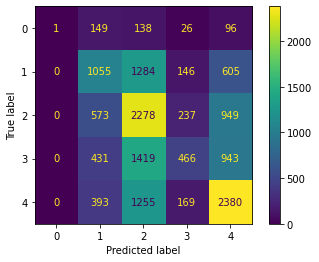

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn import metrics

# making confusion matrix
confusion = confusion_matrix(train_sentimental.AdoptionSpeed, y_preds)

# plotting confusion matrix

ConfusionMatrixDisplay(
    confusion_matrix=confusion, display_labels=pipe_best.classes_
).plot()

Looking into confusion matrix, I can see that **most accurately** predicted is **class 4** (no adoption after 100 days). Unsurprisingly, this class is the most numerous in the dataset. In the meantime, **the least accurately** predicted are **class 3** ((pet adopted between 31 - 90 days) it's most frequently misclassified as class 2 (pet adopted between 8 - 30 days)) and **class 0** (adopted on the same day), which has only 1 accurate prediction out of 410 cases.

In [ ]:
print(metrics.classification_report(target, y_preds))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       410
           1       0.41      0.34      0.37      3090
           2       0.36      0.56      0.44      4037
           3       0.45      0.14      0.22      3259
           4       0.48      0.57      0.52      4197

    accuracy                           0.41     14993
   macro avg       0.54      0.32      0.31     14993
weighted avg       0.44      0.41      0.39     14993



Classification report again confirms the findings in confusion matrix. The lowest f1-score (0.00) goes to class 0, while class 4 achieves the highest score (0.52).